In [22]:
#load in the libraries
import numpy as np
import pandas as pd
import plotly.graph_objects as go
from tqdm.notebook import tqdm
from sklearn.model_selection import RepeatedKFold
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, log_loss
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score, KFold
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
from sklearn.inspection import partial_dependence, plot_partial_dependence
from matplotlib.pyplot import figure
from bayes_opt import BayesianOptimization
from sklearn.metrics import mean_squared_error
from statistics import mean
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import StratifiedKFold
from nested_cv import NestedCV
from IPython.display import Image
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import plot_roc_curve
from sklearn.model_selection import train_test_split
import seaborn as sns

In [3]:
#make function to match the status for what ever parasite it is, binarize it, and drop unnecessary columns
def gettrain(df, parasite):
    #matching the sandfly status for the species of parasite to the sandfly in the larger dataframe
    for j in range(len(df)):
        for i in range(len(status)):
            if df.loc[j, 'species'] == status.loc[i, 'species']:
                df.loc[j, parasite] = status.loc[i, parasite]
    #fill the remaining vector status column with 0s, then binarize the status
    df[parasite] = df[parasite].fillna(0).map(lambda x : x//2)
    #set the index as the species name
    train = df.set_index('species')
    #drop unnecessary columns
    train = train.drop(columns=['Unnamed: 0', '.imp', '.id'])
    if 'index' in df.columns:
        train = train.drop(columns=['index'])
    
    return train

In [412]:
#code taken from https://towardsdatascience.com/calculating-confidence-interval-with-bootstrapping-872c657c058d
#use the bootstrap methos to make make a confidence interval
def draw_bs_replicates(data,func,size):
    """creates a bootstrap sample, computes replicates and returns replicates array"""
    # Create an empty array to store replicates
    bs_replicates = np.empty(size)
    
    # Create bootstrap replicates as much as size
    for i in range(size):
        # Create a bootstrap sample
        bs_sample = np.random.choice(data,size=len(data))
        # Get bootstrap replicate and append to bs_replicates
        bs_replicates[i] = func(bs_sample)
    
    return bs_replicates

# print the averages and the confidence interval
def getconf_interval(data):
    # Draw 15000 bootstrap replicates
    bs_replicates_aucs = draw_bs_replicates(data,np.mean,15000)

    # Print empirical mean
    print("Empirical mean: " + str(round(np.mean(data), 3)))

    # Print the mean of bootstrap replicates
    print("Bootstrap replicates mean: " + str(round(np.mean(bs_replicates_aucs), 3)))

    # Get the corresponding values of 2.5th and 97.5th percentiles
    conf_interval = np.percentile(bs_replicates_aucs,[2.5,97.5])

    # Print the interval
    print("The confidence interval: ", np.round(conf_interval, 3))


# return the confidence interval
def getconf_interval_var(data):
    # Draw 15000 bootstrap replicates
    bs_replicates_aucs = draw_bs_replicates(data,np.mean,15000)

    # Get the corresponding values of 2.5th and 97.5th percentiles
    conf_interval = np.percentile(bs_replicates_aucs,[2.5,97.5])
    
    return conf_interval

#get imp100, a dataframe of the variable importances across the ten models
def fscore(list_of_models):
    #takes in modelslist created in the predtable function
    #make a list of the most important variables for each model
    importancelist = []
    for x in range(100):
        importancelist.append(pd.DataFrame(list_of_models[x].get_booster().get_fscore().items(), columns=['feature','importance']).sort_values('importance', ascending=False))

    #make a dataframe of all the dataframes in importancelist
    imp100 = pd.DataFrame()
    for i in range(100):
        imp100 = imp100.append(importancelist[i], ignore_index = True)
                
    return imp100

#takes in modelslist created in the predtable function
def var_impt(list_of_models):

    #add the importances of each feature and arrange them in decreasing order
    mean = fscore(list_of_models).groupby('feature').mean().sort_values(by='importance', ascending=False).reset_index()
    std = fscore(list_of_models).groupby('feature').std().sort_values(by='importance', ascending=False).reset_index()
    count = pd.DataFrame(fscore(list_of_models)['feature'].value_counts()).reset_index()

    #get std into dataframes
    for x in range(len(mean)):
        for y in range(len(std)):
            if mean.loc[x, 'feature'] == std.loc[y, 'feature']:
                mean.loc[x, 'std'] = std.loc[y, 'importance']
        #get count of variables
        for z in range(len(count)):
            if mean.loc[x, 'feature'] == count.loc[z, 'index']:
                mean.loc[x, 'count'] = count.loc[z, 'feature'] 
                
    return mean.round(3)

# proven

In [737]:
def getstatus(df, parasite):
    for i in range(len(status)):
        for j in range(len(df)):
            if status.loc[i, 'species'] == df.loc[j, 'species']:
                df.loc[j, 'potential/proven'] = status.loc[i, parasite]
    df = df.fillna(0)
    return df

### clean the original dataset

In [766]:
original = pd.read_csv('final2/one hot encoded original data.csv')
original = original.drop(columns=['Argentina', 'Belize','Bolivia', 'Brazil', 'Canada', 'CaymanIslands', 'Chile', 'Colombia', 'Costa.Rica', 'Cuba', 'Dominican.Republic', 'Ecuador', 'El.Salvador', 'French.Guiana','Guadeloupe', 'Guatemala', 'Grenada', 'Guyana', 'Haiti', 'Honduras', 'Jamaica','Martinica', 'Mexico', 'Nicaragua', 'Panama', 'Paraguay','PuertoRico', 'Peru', 'Suriname', 'TrinidadTobago', 'Uruguay', 'USA', 'Venezuela','VirginIslands'])
status = pd.read_csv('final2/sandfly status.csv')
#if sandfly is a proven vector for any species of leish, mark it in a new column 'cl' as 1
status['leish'] = 0
for i in range(len(status)):
    if 2 in status.values.tolist()[i]:
        status.loc[i, 'leish'] = 2
    elif 1 in status.values.tolist()[i]:
        status.loc[i, 'leish'] = 1

#get cleaned train datasets in a list
parasite = 'leish'
for j in range(len(original)):
    for i in range(len(status)):
        if original.loc[j, 'species'] == status.loc[i, 'species']:
            original.loc[j, parasite] = status.loc[i, parasite]

#fill the remaining vector status column with 0s, then binarize the status
original[parasite] = original[parasite].fillna(0).map(lambda x : x//2)
#set the index as the species name
original = original.set_index('species')
#drop unnecessary columns
original_clean = original.drop(columns=['Unnamed: 0'])

In [739]:
####LOOK AT CORRELLATED VARIABLES??
#tribe_Hertigiini is corr w 'genus_Warileya'
#subtribe_hertigiina is corr w 'genus_Warileya'
#peri is corr w semi.domestic
#'genus_Brumptomyia' is corr w 'subtribe_Brumptomyiina'
#'genus_Micropygomyia' is corr w 'subtribe_Sergentomyiina'
#
# pd.DataFrame(original_clean.corr()).to_csv('correllation.csv')
original_clean = original_clean.drop(columns=['subtribe_Sergentomyiina', 'subtribe_Brumptomyiina',
                                              'peri', 'subtribe_Hertigiina', 'tribe_Hertigiini'])

# citation prediction - xgbregressor

In [724]:
#if the model performs super bad, then no need to do a w/o citations analysis

In [605]:
data_c = original_clean.iloc[:,:-1].drop(columns = ['log.citations'])
c = original_clean.iloc[:,:-1]['log.citations']
data_c['log.citations'] = c

In [616]:
#####code taken from https://www.kaggle.com/felipefiorini/xgboost-hyper-parameter-tuning



def hyperParameterTuning(X_train, y_train):
    param_tuning = {
        'learning_rate': [0.01, 0.1],
        'max_depth': [3, 5, 7, 10],
        'min_child_weight': [1, 3, 5],
        'subsample': [0.5, 0.7],
        'colsample_bytree': [0.5, 0.7],
        'n_estimators' : [100, 200, 500],
        'objective': ['reg:squarederror']
    }

    xgb_model = XGBRegressor()

    gsearch = GridSearchCV(estimator = xgb_model,
                           param_grid = param_tuning,                        
                           #scoring = 'neg_mean_absolute_error', #MAE
                           #scoring = 'neg_mean_squared_error',  #MSE
                           cv = 5,
                           n_jobs = -1,
                           verbose = 1)

    gsearch.fit(X_train,y_train)

    return gsearch.best_params_

In [646]:
data = data_c
X, y = data.iloc[:,:-1],data.iloc[:,-1]
data_dmatrix = xgb.DMatrix(data=X,label=y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [661]:
hyperParameterTuning(X_train, y_train)

Fitting 5 folds for each of 288 candidates, totalling 1440 fits


{'colsample_bytree': 0.7,
 'learning_rate': 0.01,
 'max_depth': 3,
 'min_child_weight': 1,
 'n_estimators': 500,
 'objective': 'reg:squarederror',
 'subsample': 0.7}

In [662]:
params = {'colsample_bytree': 0.7,
 'learning_rate': 0.01,
 'max_depth': 3,
 'min_child_weight': 1,
 'n_estimators': 500,
 'objective': 'reg:squarederror',
 'subsample': 0.7}
xgb_model = XGBRegressor(**params)

In [663]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
xgb_model.fit(X_train, y_train)

y_pred_xgb = xgb_model.predict(X_test)

mae_xgb = mean_absolute_error(y_test, y_pred_xgb)

In [664]:
xgb_model.score(X_train,y_train)

0.48843990280339533

In [665]:
len(a)

103

## target shuffling - make sure its getting shuffled properly

In [786]:
data = original_clean.reset_index()
data['leish'] = 0
l = data[['species', 'leish']]

In [798]:
## From the hyperopt docs

from hyperopt import hp
from hyperopt import fmin, tpe
'''
## For the argument named 'a', choose either of the two tuples, each of which has a second
## argument drawn from a given distribution and given a name ('c1'/'c2')
space = hp.choice('a',
    [
        ('case 1', 1 + hp.lognormal('c1', 0, 1)),
        ('case 2', hp.uniform('c2', -10, 10))
    ])

# minimize the objective over the space
from hyperopt import fmin, tpe, space_eval
best = fmin(objective, space, algo=tpe.suggest, max_evals=100)

'''
###TRY TO GET THE AUC, CHANGE THE THRESHHOLD PROBABILITY

def val_test(best, train_x, train_y, val_x, val_y, graph=False):
    params = {'max_depth': int(best['max_depth']), 'gamma': best['gamma'],
                  'learning_rate': best['learning_rate'], 'n_estimators': int(best['n_estimators']),
                  'scale_pos_weight': int(best['scale_pos_weight']), 'colsample_bytree': best['colsample_bytree']}
    model = XGBClassifier(use_label_encoder=False, eval_metric = 'logloss', **params)
    model.fit(train_x, train_y)

    

    #use the mean of the probabilities as the threshold for a positive prediction
    prob = np.array(pd.DataFrame(model.predict_proba(val_x))[1])
    for x in range(len(prob)):
        if prob[x] > mean(np.array(pd.DataFrame(model.predict_proba(val_x))[1])):
            prob[x] = 1
        else:
            prob[x] = 0
        
    y_preds = prob
    
               
#         plot_roc_curve(model, val_x, val_y)
#         plt.ylabel('True Positive Rate')
#         plt.xlabel('False Positive Rate')
#         plt.show()
               
    return roc_auc_score(val_y, y_preds)

target_shuffle = []
def do_nested_cv(data):
    '''
    - Split data into train, test
    - Split train into k (stratified) folds
    '''
    
    # Begin code here
    X, y = data.iloc[:,:-1], data.iloc[:,-1]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify = y)
    
    cv = StratifiedKFold(n_splits=3)
    folds = cv.split(X_train, y_train)
    

    
    # End code here
    models_with_scores = []
    for (train, val) in folds:
        '''
        - Split x into n more (stratified) folds
        - Now, use Bayesian optimization to minimize objective function
        - After Bayesian optimization, evaluate the model on val and store the model
        '''
        # Begin code here
        train_x, train_y = X_train.iloc[train], y_train.iloc[train]
        val_x, val_y = X_train.iloc[val], y_train.iloc[val]
        inner_cv = StratifiedKFold(n_splits=3)
        
        inner_folds = inner_cv.split(train_x, train_y)
        inner_folds = [(train,test) for train, test in inner_folds]
        
        def objective_function(params):
            '''
            Given a set of n (inner) folds, train n models and return the average validation loss over all folds.
            '''
            scores = []
            params = {'max_depth': int(params[0]), 'gamma': params[1],
                      'learning_rate': params[2], 'n_estimators': int(params[3]),
                      'scale_pos_weight': int(params[4]), 'colsample_bytree': params[5]}

            for (itrain, ival) in inner_folds:
                # Begin code here
                '''
                - Train a model on n
                - Evaluate on val
                - Store the score to return the average over all folds
                '''
                inner_train_x, inner_train_y = train_x.iloc[itrain], train_y.iloc[itrain]
                inner_val_x, inner_val_y = train_x.iloc[ival], train_y.iloc[ival]
                
                

                model = XGBClassifier(use_label_encoder=False, eval_metric = 'logloss', **params)
                model.fit(inner_train_x, inner_train_y)
            
                y_preds = model.predict(inner_val_x)
                scores.append(1-roc_auc_score(inner_val_y, y_preds))

            return np.mean(scores)
                # End code here
            
        
        #bayes

        space = hp.choice('a', [(hp.uniform('max_depth', 0, 10),
                                 hp.uniform('gamma', 10, 1000), 
                                 hp.uniform('learning_rate', 0, 1), 
                                 hp.uniform('n_estimators', 100, 200),
                                 hp.uniform('scale_pos_weight', 0, 15),
                                 hp.uniform('colsample_bytree', 0.2, 1)
                                )])
        

            
        best = fmin(objective_function, space, algo=tpe.suggest, max_evals=100)
        models_with_scores.append((best, val_test(best, train_x, train_y, val_x, val_y)))
        
        target_shuffle.append((best, val_test(best, train_x, train_y, val_x, val_y)))

        # End code here
        

    
    '''
    - Now, there are k models. Pick the best one, or create an ensemble model
    '''
    # Begin code here
    models_with_scores = sorted(models_with_scores, key = lambda x: x[1])
    best_params_overall = models_with_scores[-1][0]
    
    final_test_score = val_test(best_params_overall, X_train, y_train, X_test, y_test, True)
    print("Final Test Score is " + str(final_test_score))
    print('best = ' + str(best_params_overall))
    # End code here
    


In [813]:
#do shuffling and nested cv


for i in range(50):
    data = original_clean.reset_index()
    l = data[['species', 'leish']]
    #shuffle leish column
    shuffle = pd.DataFrame(l.sample(frac = 0.078))
    data['leish'] = 0
    for j in range(len(data)):
        for i in range(len(shuffle)):
            if data.loc[j, 'species'] == shuffle.reset_index().loc[i, 'species']:
                data.loc[j, 'leish'] = 1
    data = data.set_index('species')
    do_nested_cv(data)

100%|█████████████████████████████████████████████████████████████| 100/100 [01:21<00:00,  1.23trial/s, best loss: 0.5]
Final Test Score is 0.39868421052631575
best = {'a': 0, 'colsample_bytree': 0.42680570549609737, 'gamma': 10.737377455382958, 'learning_rate': 0.005385125573492548, 'max_depth': 6.837880339246453, 'n_estimators': 166.85484004694615, 'scale_pos_weight': 12.596058604241607}
100%|██████████████████████████████████████████████| 100/100 [01:13<00:00,  1.35trial/s, best loss: 0.4067460317460318]
Final Test Score is 0.5342105263157895
best = {'a': 0, 'colsample_bytree': 0.5012445069456858, 'gamma': 10.595284940359917, 'learning_rate': 0.6819288002338191, 'max_depth': 5.53836032776211, 'n_estimators': 103.6620141486637, 'scale_pos_weight': 8.45437423604087}
100%|█████████████████████████████████████████████████████████████| 100/100 [01:26<00:00,  1.16trial/s, best loss: 0.5]
Final Test Score is 0.5
best = {'a': 0, 'colsample_bytree': 0.616266664966799, 'gamma': 949.7608514268

100%|█████████████████████████████████████████████████████████████| 100/100 [01:27<00:00,  1.14trial/s, best loss: 0.5]
Final Test Score is 0.5
best = {'a': 0, 'colsample_bytree': 0.9865535650168087, 'gamma': 74.35936133828282, 'learning_rate': 0.7609972917171326, 'max_depth': 7.0248386257654305, 'n_estimators': 134.07176663614337, 'scale_pos_weight': 0.019347396507312098}
100%|██████████████████████████████████████████████| 100/100 [01:21<00:00,  1.22trial/s, best loss: 0.4444444444444445]
Final Test Score is 0.4769736842105263
best = {'a': 0, 'colsample_bytree': 0.45337724925179756, 'gamma': 12.443133136013614, 'learning_rate': 0.5408534512477071, 'max_depth': 3.1160981476676772, 'n_estimators': 194.94539090569435, 'scale_pos_weight': 6.086324976896552}
100%|█████████████████████████████████████████████| 100/100 [01:16<00:00,  1.31trial/s, best loss: 0.49603174603174605]
Final Test Score is 0.5348684210526315
best = {'a': 0, 'colsample_bytree': 0.6125313929201004, 'gamma': 30.6967100

100%|█████████████████████████████████████████████████████████████| 100/100 [01:21<00:00,  1.23trial/s, best loss: 0.5]
Final Test Score is 0.5
best = {'a': 0, 'colsample_bytree': 0.5342622333858686, 'gamma': 458.62346293621715, 'learning_rate': 0.9022349276315355, 'max_depth': 0.2780182827388933, 'n_estimators': 140.78564498173907, 'scale_pos_weight': 8.297817933219903}
100%|█████████████████████████████████████████████| 100/100 [01:26<00:00,  1.16trial/s, best loss: 0.43452380952380953]
Final Test Score is 0.5
best = {'a': 0, 'colsample_bytree': 0.36251624698918994, 'gamma': 144.53301285719579, 'learning_rate': 0.6003895151433781, 'max_depth': 9.194276359469603, 'n_estimators': 127.03458586393309, 'scale_pos_weight': 10.411102245720278}
100%|█████████████████████████████████████████████| 100/100 [01:23<00:00,  1.20trial/s, best loss: 0.44047619047619047]
Final Test Score is 0.5
best = {'a': 0, 'colsample_bytree': 0.8872800608328566, 'gamma': 927.2266385470706, 'learning_rate': 0.8147

100%|█████████████████████████████████████████████████████████████| 100/100 [01:25<00:00,  1.17trial/s, best loss: 0.5]
Final Test Score is 0.5
best = {'a': 0, 'colsample_bytree': 0.9406427582744261, 'gamma': 913.663271088753, 'learning_rate': 0.40441586395650353, 'max_depth': 1.13585412590812, 'n_estimators': 165.96558135308655, 'scale_pos_weight': 11.18818977518339}
100%|█████████████████████████████████████████████| 100/100 [01:38<00:00,  1.02trial/s, best loss: 0.45436507936507936]
Final Test Score is 0.4822368421052632
best = {'a': 0, 'colsample_bytree': 0.4328292516874105, 'gamma': 11.171223513981943, 'learning_rate': 0.9899392429331391, 'max_depth': 6.221914625137405, 'n_estimators': 196.21695825487194, 'scale_pos_weight': 6.161360799989244}
100%|█████████████████████████████████████████████████████████████| 100/100 [01:26<00:00,  1.15trial/s, best loss: 0.5]
Final Test Score is 0.5
best = {'a': 0, 'colsample_bytree': 0.22112302896821925, 'gamma': 373.3660075449328, 'learning_ra

In [814]:
np.mean([target_shuffle[x][1] for x in range(50)])

0.5021402597402598

# actual model

In [691]:
## From the hyperopt docs

from hyperopt import hp
from hyperopt import fmin, tpe
'''
## For the argument named 'a', choose either of the two tuples, each of which has a second
## argument drawn from a given distribution and given a name ('c1'/'c2')
space = hp.choice('a',
    [
        ('case 1', 1 + hp.lognormal('c1', 0, 1)),
        ('case 2', hp.uniform('c2', -10, 10))
    ])

# minimize the objective over the space
from hyperopt import fmin, tpe, space_eval
best = fmin(objective, space, algo=tpe.suggest, max_evals=100)

'''
###TRY TO GET THE AUC, CHANGE THE THRESHHOLD PROBABILITY

def val_test(best, train_x, train_y, val_x, val_y, graph=False):
    params = {'max_depth': int(best['max_depth']), 'gamma': best['gamma'],
                  'learning_rate': best['learning_rate'], 'n_estimators': int(best['n_estimators']),
                  'scale_pos_weight': int(best['scale_pos_weight']), 'colsample_bytree': best['colsample_bytree']}
    model = XGBClassifier(use_label_encoder=False, eval_metric = 'logloss', **params)
    model.fit(train_x, train_y)

    

    #use the mean of the probabilities as the threshold for a positive prediction
    prob = np.array(pd.DataFrame(model.predict_proba(val_x))[1])
    for x in range(len(prob)):
        if prob[x] > mean(np.array(pd.DataFrame(model.predict_proba(val_x))[1])):
            prob[x] = 1
        else:
            prob[x] = 0
        
    y_preds = prob
    
               
#         plot_roc_curve(model, val_x, val_y)
#         plt.ylabel('True Positive Rate')
#         plt.xlabel('False Positive Rate')
#         plt.show()
               
    return roc_auc_score(val_y, y_preds)

original_models = []
def do_nested_cv(data):
    '''
    - Split data into train, test
    - Split train into k (stratified) folds
    '''
    
    # Begin code here
    X, y = data.iloc[:,:-1], data.iloc[:,-1]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify = y)
    
    cv = StratifiedKFold(n_splits=3)
    folds = cv.split(X_train, y_train)
    

    
    # End code here
    models_with_scores = []
    for (train, val) in folds:
        '''
        - Split x into n more (stratified) folds
        - Now, use Bayesian optimization to minimize objective function
        - After Bayesian optimization, evaluate the model on val and store the model
        '''
        # Begin code here
        train_x, train_y = X_train.iloc[train], y_train.iloc[train]
        val_x, val_y = X_train.iloc[val], y_train.iloc[val]
        inner_cv = StratifiedKFold(n_splits=3)
        
        inner_folds = inner_cv.split(train_x, train_y)
        inner_folds = [(train,test) for train, test in inner_folds]
        
        def objective_function(params):
            '''
            Given a set of n (inner) folds, train n models and return the average validation loss over all folds.
            '''
            scores = []
            params = {'max_depth': int(params[0]), 'gamma': params[1],
                      'learning_rate': params[2], 'n_estimators': int(params[3]),
                      'scale_pos_weight': int(params[4]), 'colsample_bytree': params[5]}

            for (itrain, ival) in inner_folds:
                # Begin code here
                '''
                - Train a model on n
                - Evaluate on val
                - Store the score to return the average over all folds
                '''
                inner_train_x, inner_train_y = train_x.iloc[itrain], train_y.iloc[itrain]
                inner_val_x, inner_val_y = train_x.iloc[ival], train_y.iloc[ival]
                
                

                model = XGBClassifier(use_label_encoder=False, eval_metric = 'logloss', **params)
                model.fit(inner_train_x, inner_train_y)
            
                y_preds = model.predict(inner_val_x)
                scores.append(1-roc_auc_score(inner_val_y, y_preds))

            return np.mean(scores)
                # End code here
            
        
        #bayes

        space = hp.choice('a', [(hp.uniform('max_depth', 0, 10),
                                 hp.uniform('gamma', 10, 1000), 
                                 hp.uniform('learning_rate', 0, 1), 
                                 hp.uniform('n_estimators', 100, 200),
                                 hp.uniform('scale_pos_weight', 0, 15),
                                 hp.uniform('colsample_bytree', 0.2, 1)
                                )])
        

            
        best = fmin(objective_function, space, algo=tpe.suggest, max_evals=100)
        models_with_scores.append((best, val_test(best, train_x, train_y, val_x, val_y)))
        
        original_models.append((best, val_test(best, train_x, train_y, val_x, val_y)))

        # End code here
        

    
    '''
    - Now, there are k models. Pick the best one, or create an ensemble model
    '''
    # Begin code here
    models_with_scores = sorted(models_with_scores, key = lambda x: x[1])
    best_params_overall = models_with_scores[-1][0]
    
    final_test_score = val_test(best_params_overall, X_train, y_train, X_test, y_test, True)
    print("Final Test Score is " + str(final_test_score))
    print('best = ' + str(best_params_overall))
    # End code here
    


In [270]:
### get out a list *original_models* that has the parameters and aucs

for i in range(100):
    data = original_clean
    do_nested_cv(data)

100%|█████████████████████████████████████████████| 100/100 [01:15<00:00,  1.32trial/s, best loss: 0.24169000933706816]
Final Test Score is 0.6592261904761905
best = {'a': 0, 'colsample_bytree': 0.7498282116351427, 'gamma': 118.44651554159304, 'learning_rate': 0.021968930641191375, 'max_depth': 2.9012209750331137, 'n_estimators': 162.29523631865376, 'scale_pos_weight': 14.715204784239827}
100%|█████████████████████████████████████████████| 100/100 [01:32<00:00,  1.09trial/s, best loss: 0.21402894491129787]
Final Test Score is 0.8229166666666666
best = {'a': 0, 'colsample_bytree': 0.6225042075068249, 'gamma': 63.79780930567266, 'learning_rate': 0.19633256626961632, 'max_depth': 7.559960506180868, 'n_estimators': 129.3147828498432, 'scale_pos_weight': 13.23750713778975}
100%|██████████████████████████████████████████████| 100/100 [01:21<00:00,  1.22trial/s, best loss: 0.1844304388422036]
Final Test Score is 0.8244047619047619
best = {'a': 0, 'colsample_bytree': 0.34593721990366716, 'gamm

100%|██████████████████████████████████████████████| 100/100 [01:27<00:00,  1.14trial/s, best loss: 0.2256769374416433]
Final Test Score is 0.793154761904762
best = {'a': 0, 'colsample_bytree': 0.4655129643951308, 'gamma': 12.16153919379105, 'learning_rate': 0.2824241272371274, 'max_depth': 4.716123939998577, 'n_estimators': 152.8795686255213, 'scale_pos_weight': 8.656280449216592}
100%|██████████████████████████████████████████████| 100/100 [01:12<00:00,  1.37trial/s, best loss: 0.2597572362278245]
Final Test Score is 0.7827380952380952
best = {'a': 0, 'colsample_bytree': 0.2943097532653761, 'gamma': 10.771879720028776, 'learning_rate': 0.03598020999193027, 'max_depth': 2.4960514103017735, 'n_estimators': 143.25672197480552, 'scale_pos_weight': 9.080670361352748}
100%|██████████████████████████████████████████████| 100/100 [01:20<00:00,  1.25trial/s, best loss: 0.1031045751633987]
Final Test Score is 0.7321428571428572
best = {'a': 0, 'colsample_bytree': 0.41918503655220307, 'gamma': 

100%|█████████████████████████████████████████████| 100/100 [01:14<00:00,  1.35trial/s, best loss: 0.10891690009337067]
Final Test Score is 0.6956845238095237
best = {'a': 0, 'colsample_bytree': 0.42014038185545144, 'gamma': 38.921697933202445, 'learning_rate': 0.5297776838913256, 'max_depth': 4.463019794964561, 'n_estimators': 190.55467594225522, 'scale_pos_weight': 13.41794496040326}
100%|██████████████████████████████████████████████| 100/100 [01:14<00:00,  1.35trial/s, best loss: 0.1683706816059757]
Final Test Score is 0.7477678571428572
best = {'a': 0, 'colsample_bytree': 0.5684990504337031, 'gamma': 49.40263510179336, 'learning_rate': 0.3851058720981387, 'max_depth': 3.9650059572944922, 'n_estimators': 123.09274572258192, 'scale_pos_weight': 12.563030418788923}
100%|██████████████████████████████████████████████| 100/100 [01:16<00:00,  1.31trial/s, best loss: 0.1982959850606909]
Final Test Score is 0.8087797619047619
best = {'a': 0, 'colsample_bytree': 0.7340871209932033, 'gamma'

100%|█████████████████████████████████████████████| 100/100 [01:19<00:00,  1.25trial/s, best loss: 0.17231559290382817]
Final Test Score is 0.8333333333333334
best = {'a': 0, 'colsample_bytree': 0.835680334747622, 'gamma': 44.025641430028394, 'learning_rate': 0.012019563200340172, 'max_depth': 1.3774846108411067, 'n_estimators': 196.70468002100466, 'scale_pos_weight': 14.308768363363372}
100%|█████████████████████████████████████████████| 100/100 [01:12<00:00,  1.37trial/s, best loss: 0.17224556489262374]
Final Test Score is 0.7529761904761905
best = {'a': 0, 'colsample_bytree': 0.5492430833574633, 'gamma': 52.323276329116716, 'learning_rate': 0.4083790146450704, 'max_depth': 5.892669843999913, 'n_estimators': 129.3780180720531, 'scale_pos_weight': 12.754819054371255}
100%|█████████████████████████████████████████████| 100/100 [01:17<00:00,  1.29trial/s, best loss: 0.20011671335200742]
Final Test Score is 0.8072916666666666
best = {'a': 0, 'colsample_bytree': 0.36040617547798637, 'gamm

100%|█████████████████████████████████████████████| 100/100 [01:34<00:00,  1.06trial/s, best loss: 0.16851073762838467]
Final Test Score is 0.6034226190476191
best = {'a': 0, 'colsample_bytree': 0.5754250321493087, 'gamma': 15.289230189632935, 'learning_rate': 0.9625219418230764, 'max_depth': 7.313106514062647, 'n_estimators': 193.0875814180469, 'scale_pos_weight': 11.77523085535477}
100%|██████████████████████████████████████████████| 100/100 [01:29<00:00,  1.12trial/s, best loss: 0.2260504201680672]
Final Test Score is 0.7723214285714286
best = {'a': 0, 'colsample_bytree': 0.937676157752735, 'gamma': 33.15597253505179, 'learning_rate': 0.49249160255925983, 'max_depth': 8.864233035843982, 'n_estimators': 181.7199129714995, 'scale_pos_weight': 9.404311858328462}
100%|█████████████████████████████████████████████| 100/100 [01:07<00:00,  1.48trial/s, best loss: 0.15067693744164332]
Final Test Score is 0.828125
best = {'a': 0, 'colsample_bytree': 0.33016568893924836, 'gamma': 19.062574012

100%|█████████████████████████████████████████████| 100/100 [01:12<00:00,  1.39trial/s, best loss: 0.17614379084967322]
Final Test Score is 0.8087797619047619
best = {'a': 0, 'colsample_bytree': 0.6850398280659045, 'gamma': 52.657809833413005, 'learning_rate': 0.1925493657264987, 'max_depth': 5.488515784202461, 'n_estimators': 111.18407069750434, 'scale_pos_weight': 13.955703826623084}
100%|█████████████████████████████████████████████| 100/100 [01:25<00:00,  1.17trial/s, best loss: 0.24780578898225955]
Final Test Score is 0.8333333333333334
best = {'a': 0, 'colsample_bytree': 0.8795761142098102, 'gamma': 12.574827986168838, 'learning_rate': 0.47609701971349905, 'max_depth': 1.165844838576633, 'n_estimators': 186.12086055580693, 'scale_pos_weight': 8.588368680109538}
100%|██████████████████████████████████████████████| 100/100 [01:19<00:00,  1.26trial/s, best loss: 0.2339635854341737]
Final Test Score is 0.7477678571428572
best = {'a': 0, 'colsample_bytree': 0.20019880907171544, 'gamma

100%|█████████████████████████████████████████████| 100/100 [01:14<00:00,  1.35trial/s, best loss: 0.23204948646125126]
Final Test Score is 0.8087797619047619
best = {'a': 0, 'colsample_bytree': 0.5657354908989608, 'gamma': 19.10700451855459, 'learning_rate': 0.5228815347384923, 'max_depth': 3.6362349901109208, 'n_estimators': 165.92993912370193, 'scale_pos_weight': 12.570864647705594}
100%|██████████████████████████████████████████████| 100/100 [01:25<00:00,  1.17trial/s, best loss: 0.1603408029878618]
Final Test Score is 0.859375
best = {'a': 0, 'colsample_bytree': 0.7614706823726883, 'gamma': 45.05209676442678, 'learning_rate': 0.2522176577267726, 'max_depth': 9.542821193683514, 'n_estimators': 173.31045241748234, 'scale_pos_weight': 10.953775645172371}
100%|█████████████████████████████████████████████| 100/100 [01:22<00:00,  1.21trial/s, best loss: 0.22408963585434175]
Final Test Score is 0.7373511904761905
best = {'a': 0, 'colsample_bytree': 0.6374586399324023, 'gamma': 25.490276

100%|██████████████████████████████████████████████| 100/100 [01:22<00:00,  1.21trial/s, best loss: 0.1644957983193277]
Final Test Score is 0.758184523809524
best = {'a': 0, 'colsample_bytree': 0.5868915733424487, 'gamma': 16.82575247517979, 'learning_rate': 0.6309274055362346, 'max_depth': 7.6609306060075335, 'n_estimators': 153.16441916551875, 'scale_pos_weight': 12.728613498846318}
100%|██████████████████████████████████████████████| 100/100 [01:29<00:00,  1.12trial/s, best loss: 0.2299719887955182]
Final Test Score is 0.8541666666666666
best = {'a': 0, 'colsample_bytree': 0.9565897257226794, 'gamma': 29.19019411301082, 'learning_rate': 0.44847189467795506, 'max_depth': 1.240108095250076, 'n_estimators': 170.36506603391484, 'scale_pos_weight': 6.463378495016565}
100%|█████████████████████████████████████████████| 100/100 [01:09<00:00,  1.44trial/s, best loss: 0.18604108309990663]
Final Test Score is 0.7008928571428572
best = {'a': 0, 'colsample_bytree': 0.2951782755658515, 'gamma': 

In [41]:
import pickle
# create a binary pickle file 
f = open("original_models_parameters.pkl","wb")

# write the python object (dict) to pickle file
pickle.dump(original_models,f)

# close file
f.close()

[15:04:53] WARNING: ..\src\learner.cc:573: 
Parameters: { "params" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Accuracy:  0.893
[15:04:54] WARNING: ..\src\learner.cc:573: 
Parameters: { "params" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Accuracy:  0.854
[15:04:54] WARNING: ..\src\learner.cc:573: 
Parameters: { "params" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you fi

Accuracy:  0.874
[15:05:09] WARNING: ..\src\learner.cc:573: 
Parameters: { "params" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Accuracy:  0.738
[15:05:09] WARNING: ..\src\learner.cc:573: 
Parameters: { "params" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Accuracy:  0.854
[15:05:10] WARNING: ..\src\learner.cc:573: 
Parameters: { "params" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open a

Accuracy:  0.922
[15:05:25] WARNING: ..\src\learner.cc:573: 
Parameters: { "params" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Accuracy:  0.883
[15:05:25] WARNING: ..\src\learner.cc:573: 
Parameters: { "params" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Accuracy:  0.874
[15:05:26] WARNING: ..\src\learner.cc:573: 
Parameters: { "params" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open a

Accuracy:  0.932
[15:05:42] WARNING: ..\src\learner.cc:573: 
Parameters: { "params" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Accuracy:  0.913
[15:05:42] WARNING: ..\src\learner.cc:573: 
Parameters: { "params" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Accuracy:  0.883
[15:05:43] WARNING: ..\src\learner.cc:573: 
Parameters: { "params" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open a

Accuracy:  0.913
[15:05:58] WARNING: ..\src\learner.cc:573: 
Parameters: { "params" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Accuracy:  0.893
[15:05:59] WARNING: ..\src\learner.cc:573: 
Parameters: { "params" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Accuracy:  0.903
[15:06:00] WARNING: ..\src\learner.cc:573: 
Parameters: { "params" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open a

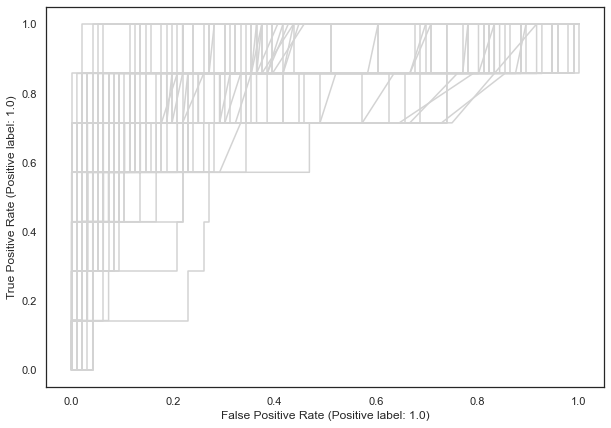

In [535]:
####
#FOR THE 10 BEST PERFORMING PARAMETERS IN ORIGINAL_MODELS, DO EVALUATIONS ON 10 RANDOM STATE SPLITS
####

param_dict = sorted(original_models, key = lambda x: x[1])[-11:-1]
fig = plt.figure()
ax = plt.subplot(111)
auc_list = []
data = original_clean

for x in range(10):
    params = {'max_depth': int(param_dict[x][0]['max_depth']), 'gamma': param_dict[x][0]['gamma'],
                              'learning_rate': param_dict[x][0]['learning_rate'], 'n_estimators': param_dict[x][0]['n_estimators'],
                              'scale_pos_weight': param_dict[x][0]['scale_pos_weight'], 'colsample_bytree': param_dict[x][0]['colsample_bytree']}
    X = data.iloc[:,:-1] # Feature matrix in pd.DataFrame format
    y = data.iloc[:,-1] # Target vector in pd.Series format
    
    for q in range(10):

        # Making train and test sets for both X and y
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify = y)

        # Instantiate an XGBoost object with hyperparameters
        xgb_clf = xgb.XGBClassifier(params = params,
                                    objective='binary:logistic', booster='gbtree', 
                                    n_jobs=2, eval_metric = 'logloss')

        # Train the model with train data sets
        xgb_clf.fit(X_train, y_train)

        prob = np.array(pd.DataFrame(xgb_clf.predict_proba(X_test))[1])
        for x in range(len(prob)):
            if prob[x] > mean(np.array(pd.DataFrame(xgb_clf.predict_proba(X_test))[1])):
                prob[x] = 1
            else:
                prob[x] = 0

        y_pred = prob
        y_true = y_test # True values

        print("Accuracy: ", np.round(accuracy_score(y_true, y_pred), 3))

        auc_list.append(roc_auc_score(y_test, xgb_clf.predict_proba(X_test)[:, 1]))

        #less ugly step curve
        plot_roc_curve(xgb_clf, X_test, y_test, color='lightgrey', ax=ax)

ax.get_legend().remove()
print(auc_list)
print('AUC: ' + str(np.mean(auc_list)))

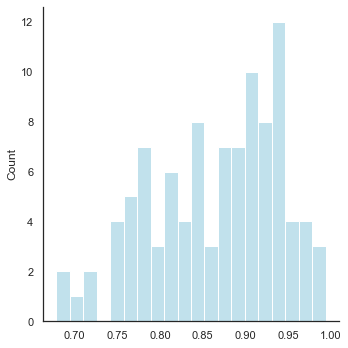

In [536]:
#from the 10 best models, 100 aucs in a histogram
sns.displot(auc_list, bins = 20, color='lightblue')
#avg = 0.865

### predictions

In [537]:
#100 iterations using random state and 10 best params
#for each best param, do 10 predictions using random states

data = original_clean
param_dict = sorted(original_models, key = lambda x: x[1])[-11:-1]
pred_list = []
prediction_matrix = pd.DataFrame(original_clean.reset_index()['species'])  
models_list = []

for x in range(10):
    params = {'max_depth': int(param_dict[x][0]['max_depth']), 'gamma': param_dict[x][0]['gamma'],
                              'learning_rate': param_dict[x][0]['learning_rate'], 'n_estimators': param_dict[x][0]['n_estimators'],
                              'scale_pos_weight': param_dict[x][0]['scale_pos_weight'], 'colsample_bytree': param_dict[x][0]['colsample_bytree']}
    
    for u in range(10):
        X, y = data.iloc[:,:-1], data.iloc[:,-1]
        #stratify to make sure the 1s are distributed evenly
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify = y)
        
        model = XGBClassifier(params=params, booster='gbtree', objective='binary:logistic', eval_metric = 'logloss')
        model.fit(X_train, y_train)
        
        models_list.append(model)

        #predictions in an array
        y = model.predict_proba(X)

        #match prediction to the species for this split
        probability_table = X.reset_index() #get the species in the test set
        probability_table['probability'] = pd.DataFrame(pd.DataFrame(y)[1]) #get the probabilities
        probability_table = probability_table[['species', 'probability']]
        #put the prediction in the big df
        for a in range(len(prediction_matrix)):
            for b in range(len(probability_table)):
                if prediction_matrix.loc[a, 'species'] == probability_table.loc[b, 'species']:
                    prediction_matrix.loc[a, str(x) + '.' + str(u)] = probability_table.loc[b, 'probability']

[15:06:57] WARNING: ..\src\learner.cc:573: 
Parameters: { "params" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:07:05] WARNING: ..\src\learner.cc:573: 
Parameters: { "params" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:07:12] WARNING: ..\src\learner.cc:573: 
Parameters: { "params" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:07:20] WARNI

[15:10:11] WARNING: ..\src\learner.cc:573: 
Parameters: { "params" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:10:18] WARNING: ..\src\learner.cc:573: 
Parameters: { "params" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:10:25] WARNING: ..\src\learner.cc:573: 
Parameters: { "params" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:10:32] WARNI

[15:13:05] WARNING: ..\src\learner.cc:573: 
Parameters: { "params" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:13:13] WARNING: ..\src\learner.cc:573: 
Parameters: { "params" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:13:20] WARNING: ..\src\learner.cc:573: 
Parameters: { "params" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:13:28] WARNI

[15:16:10] WARNING: ..\src\learner.cc:573: 
Parameters: { "params" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:16:18] WARNING: ..\src\learner.cc:573: 
Parameters: { "params" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:16:26] WARNING: ..\src\learner.cc:573: 
Parameters: { "params" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:16:34] WARNI

In [538]:
#new predictions
#CHANGED GAMMA
#get a prediction table with the mean probability and percentile for each species

prediction_matrix['probability'] = pd.DataFrame(prediction_matrix.mean(axis=1))
top_predictions = prediction_matrix
top_predictions['percentile'] = top_predictions.probability.rank(pct=True)
top_predictions = top_predictions[top_predictions['percentile'] >= 0.9].reset_index(drop=True)
top_predictions = top_predictions[['species', 'probability', 'percentile']].reset_index(drop=True)

#add real labels
top_predictions = getstatus(top_predictions, 'leish')
top_predictions = top_predictions.fillna(0)

#sort by probability
final_predictions = top_predictions.sort_values(by ='probability', ascending=False).reset_index(drop=True)
final_predictions

,species,probability,percentile,potential/proven
0,Nyssomyia whitmani,0.976510,1.000000,2.0
1,Nyssomyia intermedia,0.976455,0.998047,2.0
2,Psychodopygus ayrozai,0.974840,0.996094,2.0
3,Psychodopygus davisi,0.969397,0.994141,2.0
4,Psathyromyia (Psathyromyia) shannoni,0.962354,0.992188,2.0
5,Psychodopygus panamensis,0.953153,0.990234,2.0
6,Psychodopygus wellcomei,0.941150,0.988281,2.0
7,Lutzomyia (Lutzomyia) longipalpis,0.930978,0.986328,2.0
8,Psychodopygus complexus,0.922956,0.984375,2.0
9,Nyssomyia neivai,0.919572,0.982422,2.0


In [514]:
#CHANGED GAMMA
#get a prediction table with the mean probability and percentile for each species

prediction_matrix['probability'] = pd.DataFrame(prediction_matrix.mean(axis=1))
top_predictions = prediction_matrix
top_predictions['percentile'] = top_predictions.probability.rank(pct=True)
top_predictions = top_predictions[top_predictions['percentile'] >= 0.9].reset_index(drop=True)
top_predictions = top_predictions[['species', 'probability', 'percentile']].reset_index(drop=True)

#add real labels
top_predictions = getstatus(top_predictions, 'leish')
top_predictions = top_predictions.fillna(0)

#sort by probability
final_predictions = top_predictions.sort_values(by ='probability', ascending=False).reset_index(drop=True)
final_predictions

,species,probability,percentile,potential/proven
0,Nyssomyia antunesi,0.988353,1.000000,1.0
1,Nyssomyia whitmani,0.947182,0.998047,2.0
2,Nyssomyia intermedia,0.927506,0.996094,2.0
3,Pintomyia (Pintomyia) pessoai,0.900581,0.994141,1.0
4,Psychodopygus ayrozai,0.884780,0.992188,2.0
5,Psychodopygus davisi,0.858195,0.990234,2.0
6,Psychodopygus wellcomei,0.821285,0.988281,2.0
7,Psathyromyia (Psathyromyia) shannoni,0.810797,0.986328,2.0
8,Psychodopygus panamensis,0.735837,0.984375,2.0
9,Martinsmyia brisolai,0.730292,0.982422,0.0


### probability distributions for top sandflies

In [539]:
density = prediction_matrix.set_index('species')
density = density.loc[final_predictions['species'].to_list()]

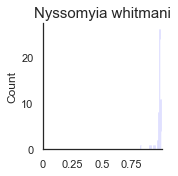

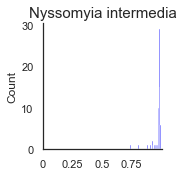

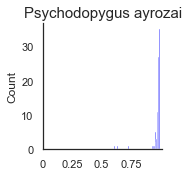

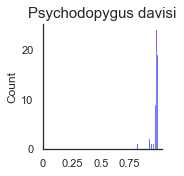

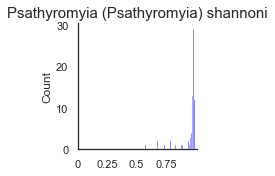

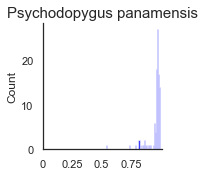

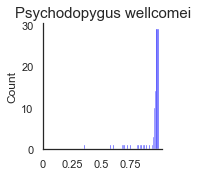

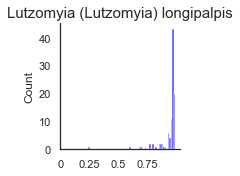

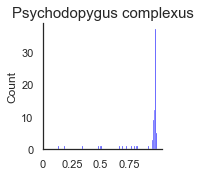

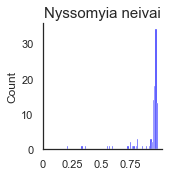

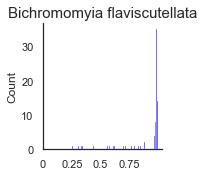

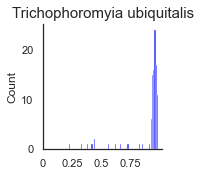

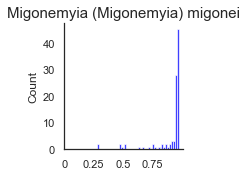

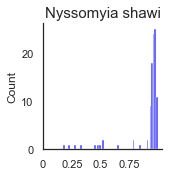

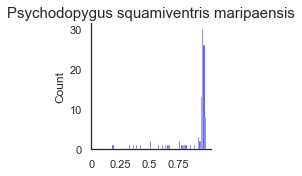

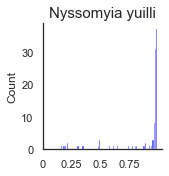

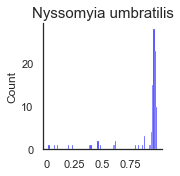

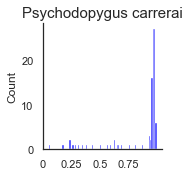

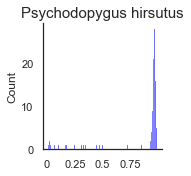

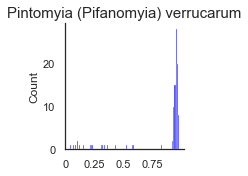

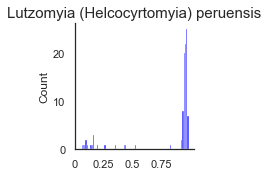

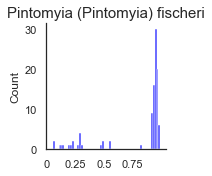

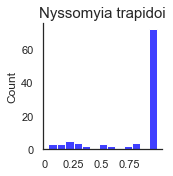

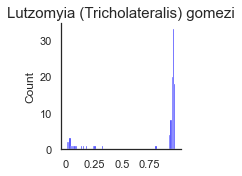

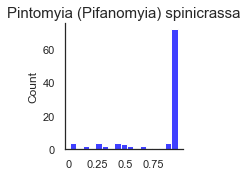

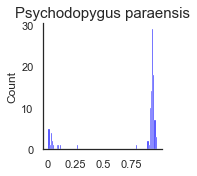

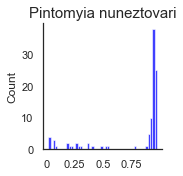

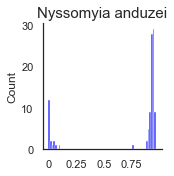

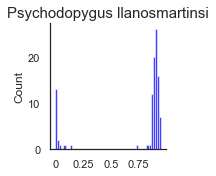

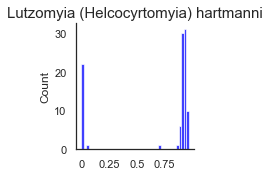

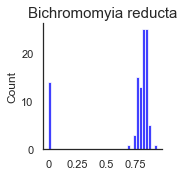

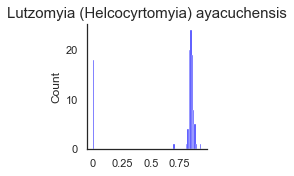

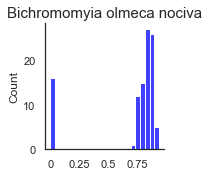

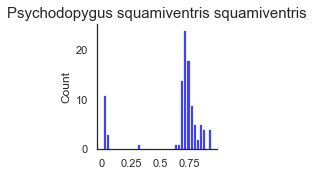

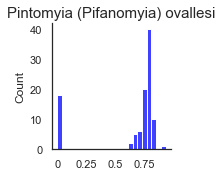

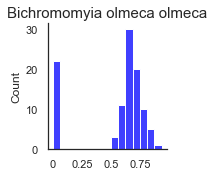

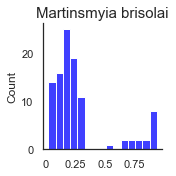

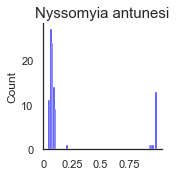

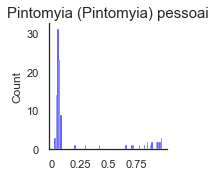

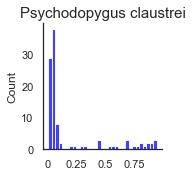

In [541]:
for x in range(40):
    sandfly = density.reset_index().loc[x, 'species']
    p = list(prediction_matrix.set_index('species').loc[sandfly])
    g = sns.displot(p, color='blue')
    g.fig.set_figwidth(2)
    g.fig.set_figheight(2)
    plt.title(sandfly, size=15)
    plt.xticks(ticks=[0, 0.25, 0.5, 0.75], labels=[0, 0.25, 0.5, 0.75])

Text(0.5, 1.0, 'Nyssomyia antunesi')

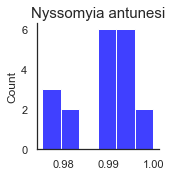

In [518]:
sandfly = 'Nyssomyia antunesi'
p = list(prediction_matrix.set_index('species').loc[sandfly])
g = sns.displot(p, color='blue')
g.fig.set_figwidth(2)
g.fig.set_figheight(2)
plt.title(sandfly, size=15)
# plt.xticks(ticks=[0, 0.25, 0.5, 0.75], labels=[0, 0.25, 0.5, 0.75])

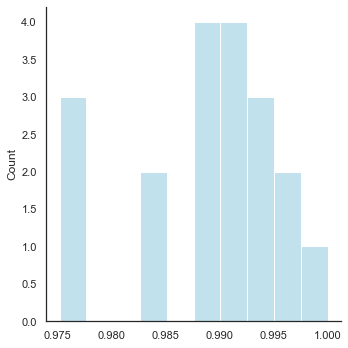

In [517]:
sandfly = 'Nyssomyia antunesi'
p = list(prediction_matrix.set_index('species').loc[sandfly])
sns.displot(p, bins = 10, color='lightblue')

### variable importance


In [542]:
#new predictions
importance = var_impt(models_list).head(40).round(3)
importance

,feature,importance,std,count
0,log.citations,68.540,21.056,100.0
1,genus_Pintomyia,26.000,9.501,95.0
2,log.ecoregion.breadth,20.730,5.932,100.0
3,bites.man,20.480,4.256,100.0
4,mh.flfs,17.694,7.639,98.0
5,log.rainfall,17.660,7.547,100.0
6,subtribe_Psychodopygina,17.580,5.271,100.0
7,log.crops.cover,13.760,5.963,100.0
8,canopy,13.590,4.776,100.0
9,flii,12.240,5.253,100.0


In [475]:
importance = var_impt(models_list).head(40).round(3)
importance

,feature,importance,std,count
0,log.citations,68.790,19.923,100.0
1,genus_Pintomyia,23.598,11.492,97.0
2,bites.man,20.820,4.708,100.0
3,log.ecoregion.breadth,19.940,5.848,100.0
4,mh.flfs,17.830,6.745,100.0
5,subtribe_Psychodopygina,17.810,5.051,100.0
6,log.rainfall,16.440,7.649,100.0
7,log.crops.cover,14.060,5.917,100.0
8,canopy,13.360,5.559,100.0
9,log.temp.var,12.690,5.486,100.0


In [454]:
#get a dataframe with the feature, and lower and higher confidence bound for its importance
var_confidence = pd.DataFrame()
var_confidence['feature'] = 0
var_confidence['lower'] = 0
var_confidence['higher'] = 0

impten = fscore(models_list)

for x in range(len(var_impt(models_list))):
    feature = var_impt(models_list)['feature'].to_list()[x]
    impt = var_impt(models_list)['importance'].to_list()[x]
    var_confidence.loc[x, 'feature'] = feature
    var_confidence.loc[x, 'importance'] = impt
    var_confidence.loc[x, 'lower'] = getconf_interval_var(impten[impten['feature'] == feature]['importance'])[0]
    var_confidence.loc[x, 'higher'] = getconf_interval_var(impten[impten['feature'] == feature]['importance'])[1]

    

In [455]:
'''
citations - red
biogeography - light blue
morphology - black
ecology - green
'''
color_list = ['red', 'black', 'green', 'lightblue', 'black', 'green', 'lightblue', 'lightblue', 'lightblue', 'lightblue',
              'lightblue', 'lightblue', 'lightblue', 'lightblue', 'lightblue', 'black', 'lightblue', 'green', 'lightblue', 'black']

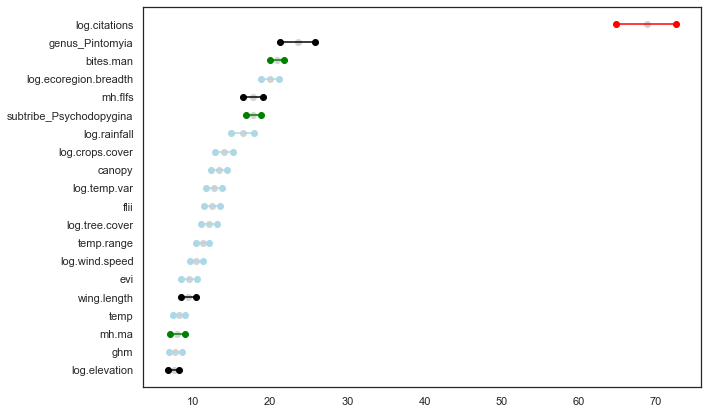

In [456]:
# plot the importances with their confidence intervals
x = var_confidence.head(20)['feature'].to_list()
y = var_confidence.head(20)['importance'].to_list()
lower = var_confidence['lower'].head(20)
higher = var_confidence['higher'].head(20)

plt.scatter(y, x, color = 'lightgrey')
#using https://stackoverflow.com/questions/59747313/how-to-plot-confidence-interval-in-python
for lower,upper,y in zip(var_confidence['lower'].head(20), var_confidence['higher'].head(20), range(len(var_confidence))):
    plt.plot((lower,upper),(y,y),'ro-',color=color_list[y])

plt.yticks(range(len(var_confidence.head(20))), list(var_confidence['feature'].head(20)))

# plt.errorbar(y, x, fmt="o")
plt.rcParams["figure.figsize"] = (15,10)
plt.gca().invert_yaxis()
# plt.show()

### pdp

In [522]:
og = pd.read_csv('final2/vector trait data final.csv')
data = original_clean
X, y = data.iloc[:,:-1], data.iloc[:,-1]

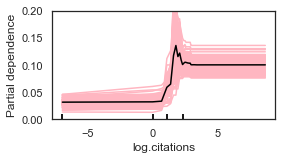

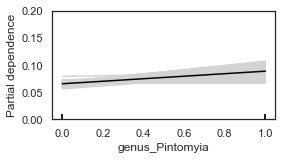

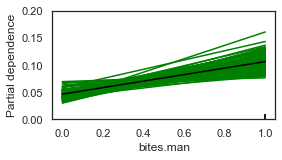

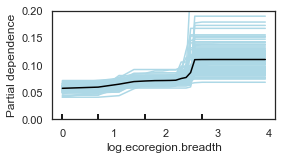

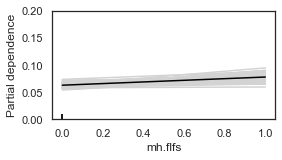

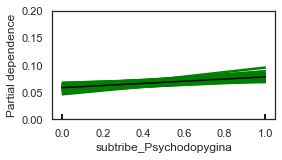

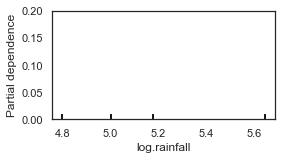

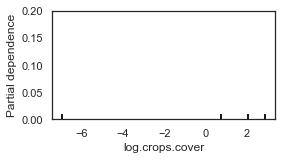

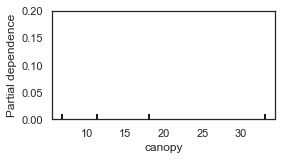

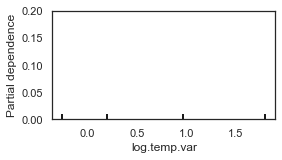

In [480]:
# fig = plt.figure()
# ax = plt.subplot(111)
model_type = models_list
color_list = ['lightpink', 'lightgrey', 'green', 'lightblue', 'lightgrey', 'green', 'lightblue', 'lightblue', 'lightblue', 'lightblue',
              'lightblue', 'lightblue', 'lightblue', 'lightblue', 'lightblue', 'lightgrey', 'lightblue', 'green', 'lightblue', 'lightgrey']

for a in range(10):
    fig = plt.figure()
    ax = plt.subplot(111)

    variable = importance.loc[a, 'feature']
    color = color_list[a]

    model0_plot = plot_partial_dependence(model_type[0], X, [variable], ax=ax,  line_kw={"color": color})
    for x in range(1, 100):
        model_plot = plot_partial_dependence(model_type[x], X, [variable], ax=model0_plot.axes_,  line_kw={"color": color})

    plt.ylim((0.0,0.2))

    #get average line
    ax = plt.gca()
    line = ax.lines[0]
    x_array = line.get_xdata()

    y_array = ax.lines[0].get_ydata()
    for i in range(1, 100):
        y_array += ax.lines[i].get_ydata()
    y_array = y_array/100
    fig.set_size_inches(4, 2)
    plt.plot(x_array, y_array, color = 'black')

# #histogram behind
# ax2 = ax.twinx()
# df_var = og['citations'].to_list()
# histogram = plt.hist(df_var, range=(0, 1), color = 'lightgrey', bins = 5, alpha = 0.4)

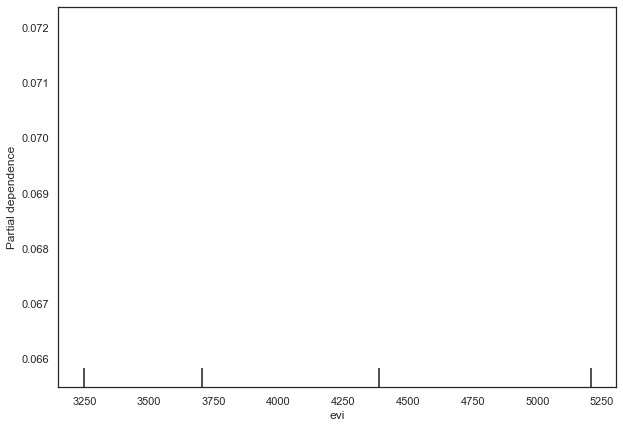

In [532]:
model_type = models_list
fig = plt.figure()
ax = plt.subplot(111)

variable = 'evi'
color = 'pink'

model0_plot = plot_partial_dependence(model_type[0], X, [variable], ax=ax,  line_kw={"color": color})
# for x in range(1, 100):
#     model_plot = plot_partial_dependence(model_type[x], X, [variable], ax=model0_plot.axes_,  line_kw={"color": color})

# plt.ylim((0.0,0.15))

#get average line
# ax = plt.gca()
# line = ax.lines[0]
# x_array = line.get_xdata()

# y_array = ax.lines[0].get_ydata()
# for i in range(1, 100):
#     y_array += ax.lines[i].get_ydata()
# y_array = y_array/100
# fig.set_size_inches(4, 2)
# plt.plot(x_array, y_array, color = 'black')
plt.show()

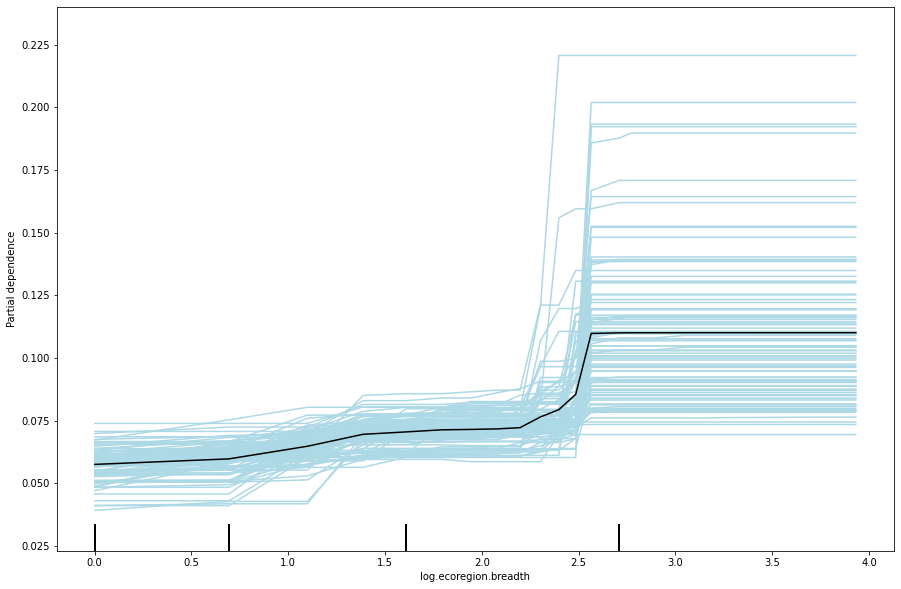

In [182]:
fig = plt.figure()
ax = plt.subplot(111)
model_type = models_list
variable = 'log.ecoregion.breadth' 
color = 'lightblue'

model0_plot = plot_partial_dependence(model_type[0], X, [variable], ax=ax,  line_kw={"color": color})
for x in range(1, 100):
    model_plot = plot_partial_dependence(model_type[x], X, [variable], ax=model0_plot.axes_,  line_kw={"color": color})

plt.ylim((0.023,0.24))

#get average line
ax = plt.gca()
line = ax.lines[0]
x_array = line.get_xdata()

y_array = ax.lines[0].get_ydata()
for i in range(1, 100):
    y_array += ax.lines[i].get_ydata()
y_array = y_array/100

plt.plot(x_array, y_array, color = 'black')

# #histogram behind
# ax2 = ax.twinx()
# df_var = original[variable].to_list()
# histogram = plt.hist(df_var, range=(0, 2), color = 'lightgrey', bins = 5, alpha = 0.4)

# no citations

In [481]:
original = pd.read_csv('final2/one hot encoded original data.csv')
original = original.drop(columns=['Argentina', 'Belize','Bolivia', 'Brazil', 'Canada', 'CaymanIslands', 'Chile', 'Colombia', 'Costa.Rica', 'Cuba', 'Dominican.Republic', 'Ecuador', 'El.Salvador', 'French.Guiana','Guadeloupe', 'Guatemala', 'Grenada', 'Guyana', 'Haiti', 'Honduras', 'Jamaica','Martinica', 'Mexico', 'Nicaragua', 'Panama', 'Paraguay','PuertoRico', 'Peru', 'Suriname', 'TrinidadTobago', 'Uruguay', 'USA', 'Venezuela','VirginIslands'])
status = pd.read_csv('final2/sandfly status.csv')
#if sandfly is a proven vector for any species of leish, mark it in a new column 'cl' as 1
status['leish'] = 0
for i in range(len(status)):
    if 2 in status.values.tolist()[i]:
        status.loc[i, 'leish'] = 2
    elif 1 in status.values.tolist()[i]:
        status.loc[i, 'leish'] = 1

#get cleaned train datasets in a list
parasite = 'leish'
for j in range(len(original)):
    for i in range(len(status)):
        if original.loc[j, 'species'] == status.loc[i, 'species']:
            original.loc[j, parasite] = status.loc[i, parasite]

#fill the remaining vector status column with 0s, then binarize the status
original[parasite] = original[parasite].fillna(0).map(lambda x : x//2)
#set the index as the species name
original = original.set_index('species')
#drop unnecessary columns
original_clean_c = original.drop(columns=['log.citations','Unnamed: 0'])

### hyper parameter optimization

In [272]:
## From the hyperopt docs

from hyperopt import hp
from hyperopt import fmin, tpe
'''
## For the argument named 'a', choose either of the two tuples, each of which has a second
## argument drawn from a given distribution and given a name ('c1'/'c2')
space = hp.choice('a',
    [
        ('case 1', 1 + hp.lognormal('c1', 0, 1)),
        ('case 2', hp.uniform('c2', -10, 10))
    ])

# minimize the objective over the space
from hyperopt import fmin, tpe, space_eval
best = fmin(objective, space, algo=tpe.suggest, max_evals=100)

'''
###TRY TO GET THE AUC, CHANGE THE THRESHHOLD PROBABILITY

def val_test(best, train_x, train_y, val_x, val_y, graph=False):
    params = {'max_depth': int(best['max_depth']), 'gamma': best['gamma'],
                  'learning_rate': best['learning_rate'], 'n_estimators': int(best['n_estimators']),
                  'scale_pos_weight': int(best['scale_pos_weight']), 'colsample_bytree': best['colsample_bytree']}
    model = XGBClassifier(use_label_encoder=False, eval_metric = 'logloss', **params)
    model.fit(train_x, train_y)

    

    #use the mean of the probabilities as the threshold for a positive prediction
    prob = np.array(pd.DataFrame(model.predict_proba(val_x))[1])
    for x in range(len(prob)):
        if prob[x] > mean(np.array(pd.DataFrame(model.predict_proba(val_x))[1])):
            prob[x] = 1
        else:
            prob[x] = 0
        
    y_preds = prob
               
#         plot_roc_curve(model, val_x, val_y)
#         plt.ylabel('True Positive Rate')
#         plt.xlabel('False Positive Rate')
#         plt.show()
               
    return roc_auc_score(val_y, y_preds)

no_cite_models = []
def do_nested_cv(data):
    '''
    - Split data into train, test
    - Split train into k (stratified) folds
    '''
    
    # Begin code here
    X, y = data.iloc[:,:-1], data.iloc[:,-1]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify = y)
    
    cv = StratifiedKFold(n_splits=3)
    folds = cv.split(X_train, y_train)
    

    
    # End code here
    models_with_scores = []
    for (train, val) in folds:
        '''
        - Split x into n more (stratified) folds
        - Now, use Bayesian optimization to minimize objective function
        - After Bayesian optimization, evaluate the model on val and store the model
        '''
        # Begin code here
        train_x, train_y = X_train.iloc[train], y_train.iloc[train]
        val_x, val_y = X_train.iloc[val], y_train.iloc[val]
        inner_cv = StratifiedKFold(n_splits=3)
        
        inner_folds = inner_cv.split(train_x, train_y)
        inner_folds = [(train,test) for train, test in inner_folds]
        
        def objective_function(params):
            '''
            Given a set of n (inner) folds, train n models and return the average validation loss over all folds.
            '''
            scores = []
            params = {'max_depth': int(params[0]), 'gamma': params[1],
                      'learning_rate': params[2], 'n_estimators': int(params[3]),
                      'scale_pos_weight': int(params[4]), 'colsample_bytree': params[5]}

            for (itrain, ival) in inner_folds:
                # Begin code here
                '''
                - Train a model on n
                - Evaluate on val
                - Store the score to return the average over all folds
                '''
                inner_train_x, inner_train_y = train_x.iloc[itrain], train_y.iloc[itrain]
                inner_val_x, inner_val_y = train_x.iloc[ival], train_y.iloc[ival]
                
                

                model = XGBClassifier(use_label_encoder=False, eval_metric = 'logloss', **params)
                model.fit(inner_train_x, inner_train_y)
            
                y_preds = model.predict(inner_val_x)
                scores.append(1-roc_auc_score(inner_val_y, y_preds))

            return np.mean(scores)
                # End code here
            
        
        #bayes

        space = hp.choice('a', [(hp.uniform('max_depth', 0, 10),
                                 hp.uniform('gamma', 10, 1000), 
                                 hp.uniform('learning_rate', 0, 1), 
                                 hp.uniform('n_estimators', 100, 200),
                                 hp.uniform('scale_pos_weight', 0, 15),
                                 hp.uniform('colsample_bytree', 0.2, 1)
                                )])
        

            
        best = fmin(objective_function, space, algo=tpe.suggest, max_evals=100)
        models_with_scores.append((best, val_test(best, train_x, train_y, val_x, val_y)))
        
        no_cite_models.append((best, val_test(best, train_x, train_y, val_x, val_y)))

        # End code here
        

    
    '''
    - Now, there are k models. Pick the best one, or create an ensemble model
    '''
    # Begin code here
    models_with_scores = sorted(models_with_scores, key = lambda x: x[1])
    best_params_overall = models_with_scores[-1][0]
    
    final_test_score = val_test(best_params_overall, X_train, y_train, X_test, y_test, True)
    print("Final Test Score is " + str(final_test_score))
    print('best = ' + str(best_params_overall))
    # End code here
    


In [273]:
### get out a list *no_cite_models* that has the parameters and aucs

for i in range(100):
    data = original_clean_c
    do_nested_cv(data)

100%|█████████████████████████████████████████████| 100/100 [01:26<00:00,  1.15trial/s, best loss: 0.26540616246498605]
Final Test Score is 0.8087797619047619
best = {'a': 0, 'colsample_bytree': 0.9997093547176091, 'gamma': 11.783029981294938, 'learning_rate': 0.21647370239529334, 'max_depth': 2.84133840568152, 'n_estimators': 132.98840960984725, 'scale_pos_weight': 8.342721256934444}
100%|█████████████████████████████████████████████| 100/100 [01:21<00:00,  1.23trial/s, best loss: 0.28510737628384686]
Final Test Score is 0.7879464285714286
best = {'a': 0, 'colsample_bytree': 0.7859513268767532, 'gamma': 47.70264993448555, 'learning_rate': 0.342496323344098, 'max_depth': 9.651615418124702, 'n_estimators': 116.63918593222425, 'scale_pos_weight': 12.448584707458327}
100%|█████████████████████████████████████████████| 100/100 [01:22<00:00,  1.21trial/s, best loss: 0.15261437908496733]
Final Test Score is 0.8489583333333334
best = {'a': 0, 'colsample_bytree': 0.8827996842856857, 'gamma': 5

100%|██████████████████████████████████████████████| 100/100 [01:14<00:00,  1.34trial/s, best loss: 0.2199112978524743]
Final Test Score is 0.6502976190476191
best = {'a': 0, 'colsample_bytree': 0.826551031172346, 'gamma': 35.50044609906842, 'learning_rate': 0.6749682898859992, 'max_depth': 3.6262223575930705, 'n_estimators': 140.41192216206449, 'scale_pos_weight': 9.1848412235082}
100%|██████████████████████████████████████████████| 100/100 [01:15<00:00,  1.33trial/s, best loss: 0.2256769374416433]
Final Test Score is 0.7566964285714286
best = {'a': 0, 'colsample_bytree': 0.22723171623993998, 'gamma': 67.28899508034853, 'learning_rate': 0.5142938287577925, 'max_depth': 5.1433393859933725, 'n_estimators': 123.97599387816373, 'scale_pos_weight': 11.661493633298385}
100%|██████████████████████████████████████████████| 100/100 [01:15<00:00,  1.32trial/s, best loss: 0.2434640522875817]
Final Test Score is 0.7879464285714286
best = {'a': 0, 'colsample_bytree': 0.7609058185661468, 'gamma': 6

100%|██████████████████████████████████████████████| 100/100 [01:15<00:00,  1.33trial/s, best loss: 0.1662464985994397]
Final Test Score is 0.8400297619047619
best = {'a': 0, 'colsample_bytree': 0.3739020097804494, 'gamma': 23.412131906035164, 'learning_rate': 0.5467292087849944, 'max_depth': 2.902802616371236, 'n_estimators': 144.19588223377633, 'scale_pos_weight': 12.657915257675189}
100%|█████████████████████████████████████████████| 100/100 [01:08<00:00,  1.46trial/s, best loss: 0.22205882352941175]
Final Test Score is 0.8296130952380953
best = {'a': 0, 'colsample_bytree': 0.7887921150984258, 'gamma': 12.6181152428505, 'learning_rate': 0.6053534615362176, 'max_depth': 3.9569358366739404, 'n_estimators': 112.79361816753428, 'scale_pos_weight': 6.302476178956518}
100%|██████████████████████████████████████████████| 100/100 [01:29<00:00,  1.12trial/s, best loss: 0.2892390289449113]
Final Test Score is 0.6190476190476191
best = {'a': 0, 'colsample_bytree': 0.96721277406425, 'gamma': 34

100%|█████████████████████████████████████████████| 100/100 [01:23<00:00,  1.20trial/s, best loss: 0.20392156862745092]
Final Test Score is 0.7983630952380952
best = {'a': 0, 'colsample_bytree': 0.2860420032874211, 'gamma': 77.86587138385501, 'learning_rate': 0.010993806901352099, 'max_depth': 7.952039157900322, 'n_estimators': 198.52820872143684, 'scale_pos_weight': 13.642708993823945}
100%|██████████████████████████████████████████████| 100/100 [01:13<00:00,  1.36trial/s, best loss: 0.2042717086834734]
Final Test Score is 0.859375
best = {'a': 0, 'colsample_bytree': 0.318923686824432, 'gamma': 33.17621792970762, 'learning_rate': 0.7111482596610679, 'max_depth': 7.06815215753105, 'n_estimators': 156.4315801449609, 'scale_pos_weight': 13.432335589849547}
100%|██████████████████████████████████████████████| 100/100 [01:26<00:00,  1.16trial/s, best loss: 0.2101307189542484]
Final Test Score is 0.7373511904761905
best = {'a': 0, 'colsample_bytree': 0.9560830323038757, 'gamma': 26.82752929

100%|██████████████████████████████████████████████| 100/100 [01:14<00:00,  1.34trial/s, best loss: 0.2732959850606909]
Final Test Score is 0.890625
best = {'a': 0, 'colsample_bytree': 0.8815772179693947, 'gamma': 10.718714090000397, 'learning_rate': 0.7727756473960123, 'max_depth': 1.4770956209440462, 'n_estimators': 129.16859268659908, 'scale_pos_weight': 6.263572924697724}
100%|█████████████████████████████████████████████| 100/100 [01:14<00:00,  1.34trial/s, best loss: 0.19435107376283844]
Final Test Score is 0.84375
best = {'a': 0, 'colsample_bytree': 0.2991456256759116, 'gamma': 24.02295086391507, 'learning_rate': 0.4964542227222197, 'max_depth': 2.38806896238121, 'n_estimators': 182.67507583407112, 'scale_pos_weight': 6.0031564579955425}
100%|█████████████████████████████████████████████| 100/100 [01:12<00:00,  1.38trial/s, best loss: 0.21017740429505138]
Final Test Score is 0.8087797619047619
best = {'a': 0, 'colsample_bytree': 0.644733854591108, 'gamma': 10.256314749966045, 'l

100%|█████████████████████████████████████████████| 100/100 [01:19<00:00,  1.26trial/s, best loss: 0.27544351073762835]
Final Test Score is 0.875
best = {'a': 0, 'colsample_bytree': 0.32806815105248455, 'gamma': 16.39005662012324, 'learning_rate': 0.04035813278732423, 'max_depth': 7.365398517263254, 'n_estimators': 174.52004215045577, 'scale_pos_weight': 10.696034367630087}
100%|██████████████████████████████████████████████| 100/100 [01:24<00:00,  1.19trial/s, best loss: 0.2059990662931839]
Final Test Score is 0.7723214285714286
best = {'a': 0, 'colsample_bytree': 0.9588122884229653, 'gamma': 38.659565227229535, 'learning_rate': 0.67393689876796, 'max_depth': 9.502322119465582, 'n_estimators': 101.26400366769701, 'scale_pos_weight': 11.902060006052032}
100%|█████████████████████████████████████████████| 100/100 [01:25<00:00,  1.16trial/s, best loss: 0.18034547152194205]
Final Test Score is 0.7113095238095237
best = {'a': 0, 'colsample_bytree': 0.9989195378129005, 'gamma': 25.188090032

100%|██████████████████████████████████████████████| 100/100 [01:17<00:00,  1.28trial/s, best loss: 0.2696078431372549]
Final Test Score is 0.7269345238095237
best = {'a': 0, 'colsample_bytree': 0.5158457657220822, 'gamma': 25.792520139153737, 'learning_rate': 0.47844086678478226, 'max_depth': 9.410405579432862, 'n_estimators': 126.73327466121549, 'scale_pos_weight': 13.282296493496366}
100%|██████████████████████████████████████████████| 100/100 [01:10<00:00,  1.42trial/s, best loss: 0.1565592903828198]
Final Test Score is 0.8087797619047619
best = {'a': 0, 'colsample_bytree': 0.3607228842216263, 'gamma': 19.096090483649956, 'learning_rate': 0.32039362910751307, 'max_depth': 8.383610536166065, 'n_estimators': 135.86659840669992, 'scale_pos_weight': 9.378626557060048}
100%|█████████████████████████████████████████████| 100/100 [01:19<00:00,  1.26trial/s, best loss: 0.22007469654528475]
Final Test Score is 0.7671130952380951
best = {'a': 0, 'colsample_bytree': 0.5792247650125972, 'gamma

100%|██████████████████████████████████████████████| 100/100 [01:16<00:00,  1.31trial/s, best loss: 0.1663398692810457]
Final Test Score is 0.7165178571428572
best = {'a': 0, 'colsample_bytree': 0.6995544726289804, 'gamma': 38.50975835003436, 'learning_rate': 0.9490919763104929, 'max_depth': 9.631411934245392, 'n_estimators': 113.13387121577777, 'scale_pos_weight': 14.193038769752373}
100%|██████████████████████████████████████████████| 100/100 [01:14<00:00,  1.33trial/s, best loss: 0.1564425770308123]
Final Test Score is 0.7619047619047621
best = {'a': 0, 'colsample_bytree': 0.9170650484449343, 'gamma': 44.77988911286745, 'learning_rate': 0.47701305076884637, 'max_depth': 3.6691018592411417, 'n_estimators': 133.59031640745036, 'scale_pos_weight': 14.025587641868643}
100%|█████████████████████████████████████████████| 100/100 [01:12<00:00,  1.37trial/s, best loss: 0.16640989729225023]
Final Test Score is 0.6904761904761906
best = {'a': 0, 'colsample_bytree': 0.6398305954128228, 'gamma'

### performance evaulation

[02:25:03] WARNING: ..\src\learner.cc:573: 
Parameters: { "params" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Accuracy:  0.903
[02:25:04] WARNING: ..\src\learner.cc:573: 
Parameters: { "params" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Accuracy:  0.864
[02:25:04] WARNING: ..\src\learner.cc:573: 
Parameters: { "params" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you fi

Accuracy:  0.883
[02:25:20] WARNING: ..\src\learner.cc:573: 
Parameters: { "params" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Accuracy:  0.893
[02:25:21] WARNING: ..\src\learner.cc:573: 
Parameters: { "params" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Accuracy:  0.913
[02:25:22] WARNING: ..\src\learner.cc:573: 
Parameters: { "params" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open a

Accuracy:  0.903
[02:25:38] WARNING: ..\src\learner.cc:573: 
Parameters: { "params" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Accuracy:  0.874
[02:25:38] WARNING: ..\src\learner.cc:573: 
Parameters: { "params" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Accuracy:  0.874
[02:25:39] WARNING: ..\src\learner.cc:573: 
Parameters: { "params" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open a

Accuracy:  0.806
[02:25:55] WARNING: ..\src\learner.cc:573: 
Parameters: { "params" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Accuracy:  0.893
[02:25:56] WARNING: ..\src\learner.cc:573: 
Parameters: { "params" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Accuracy:  0.932
[02:25:56] WARNING: ..\src\learner.cc:573: 
Parameters: { "params" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open a

Accuracy:  0.845
[02:26:15] WARNING: ..\src\learner.cc:573: 
Parameters: { "params" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Accuracy:  0.903
[02:26:16] WARNING: ..\src\learner.cc:573: 
Parameters: { "params" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Accuracy:  0.864
[02:26:16] WARNING: ..\src\learner.cc:573: 
Parameters: { "params" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open a

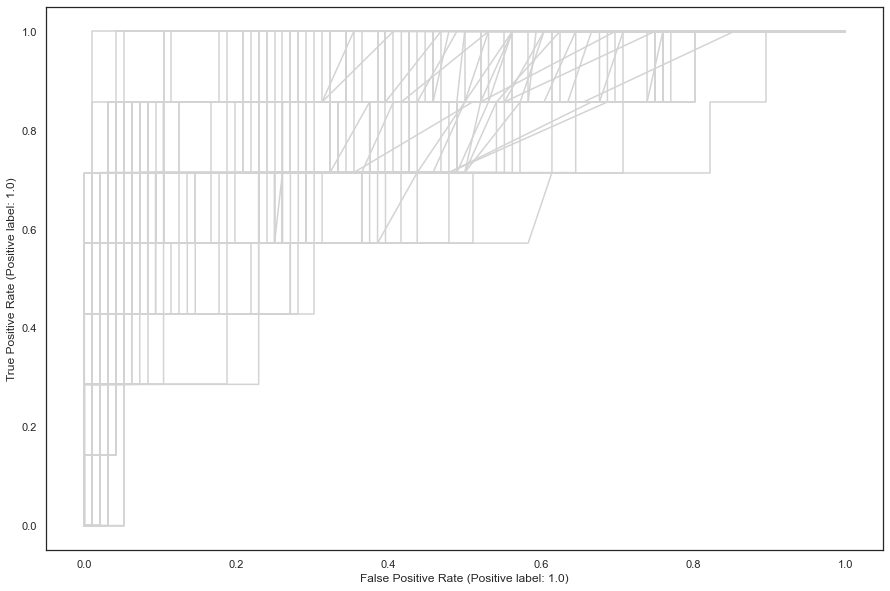

In [482]:
####
#FOR THE 10 BEST PERFORMING PARAMETERS IN no_cite_models, DO EVALUATIONS ON 10 RANDOM STATE SPLITS
####

param_dict = sorted(no_cite_models, key = lambda x: x[1])[-11:-1]
fig = plt.figure()
ax = plt.subplot(111)
auc_list = []
data = original_clean_c

for x in range(10):
    params = {'max_depth': int(param_dict[x][0]['max_depth']), 'gamma': param_dict[x][0]['gamma'],
                              'learning_rate': param_dict[x][0]['learning_rate'], 'n_estimators': param_dict[x][0]['n_estimators'],
                              'scale_pos_weight': param_dict[x][0]['scale_pos_weight'], 'colsample_bytree': param_dict[x][0]['colsample_bytree']}
    X = data.iloc[:,:-1] # Feature matrix in pd.DataFrame format
    y = data.iloc[:,-1] # Target vector in pd.Series format
    
    for q in range(10):

        # Making train and test sets for both X and y
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify = y)

        # Instantiate an XGBoost object with hyperparameters
        xgb_clf = xgb.XGBClassifier(params = params,
                                    objective='binary:logistic', booster='gbtree', 
                                    n_jobs=2, eval_metric = 'logloss')

        # Train the model with train data sets
        xgb_clf.fit(X_train, y_train)

        prob = np.array(pd.DataFrame(xgb_clf.predict_proba(X_test))[1])
        for x in range(len(prob)):
            if prob[x] > mean(np.array(pd.DataFrame(xgb_clf.predict_proba(X_test))[1])):
                prob[x] = 1
            else:
                prob[x] = 0

        y_pred = prob
        y_true = y_test # True values

        print("Accuracy: ", np.round(accuracy_score(y_true, y_pred), 3))

        auc_list.append(roc_auc_score(y_test, xgb_clf.predict_proba(X_test)[:, 1]))

        #less ugly step curve
        plot_roc_curve(xgb_clf, X_test, y_test, color='lightgrey', ax=ax)

ax.get_legend().remove()
print(auc_list)
print('AUC: ' + str(np.mean(auc_list)))

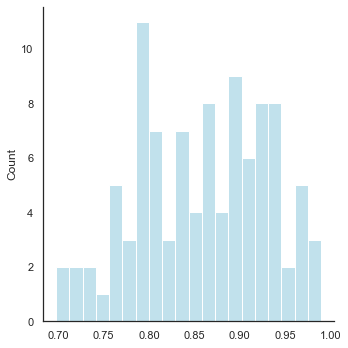

In [483]:
#from the 10 best models, 100 aucs in a histogram
sns.displot(auc_list, bins = 20, color='lightblue')

#### in sample

[09:53:34] WARNING: ..\src\learner.cc:573: 
Parameters: { "params" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Accuracy:  0.988
[09:53:37] WARNING: ..\src\learner.cc:573: 
Parameters: { "params" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Accuracy:  0.995
[09:53:40] WARNING: ..\src\learner.cc:573: 
Parameters: { "params" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you fi

Accuracy:  0.985
[09:54:45] WARNING: ..\src\learner.cc:573: 
Parameters: { "params" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Accuracy:  0.998
[09:54:48] WARNING: ..\src\learner.cc:573: 
Parameters: { "params" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Accuracy:  0.99
[09:54:51] WARNING: ..\src\learner.cc:573: 
Parameters: { "params" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an

Accuracy:  0.99
[09:55:58] WARNING: ..\src\learner.cc:573: 
Parameters: { "params" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Accuracy:  0.988
[09:56:01] WARNING: ..\src\learner.cc:573: 
Parameters: { "params" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Accuracy:  0.993
[09:56:04] WARNING: ..\src\learner.cc:573: 
Parameters: { "params" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an

Accuracy:  0.993
[09:57:10] WARNING: ..\src\learner.cc:573: 
Parameters: { "params" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Accuracy:  0.993
[09:57:12] WARNING: ..\src\learner.cc:573: 
Parameters: { "params" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Accuracy:  0.993
[09:57:15] WARNING: ..\src\learner.cc:573: 
Parameters: { "params" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open a

Accuracy:  0.99
[09:58:29] WARNING: ..\src\learner.cc:573: 
Parameters: { "params" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Accuracy:  0.995
[09:58:32] WARNING: ..\src\learner.cc:573: 
Parameters: { "params" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Accuracy:  0.99
[09:58:35] WARNING: ..\src\learner.cc:573: 
Parameters: { "params" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an 

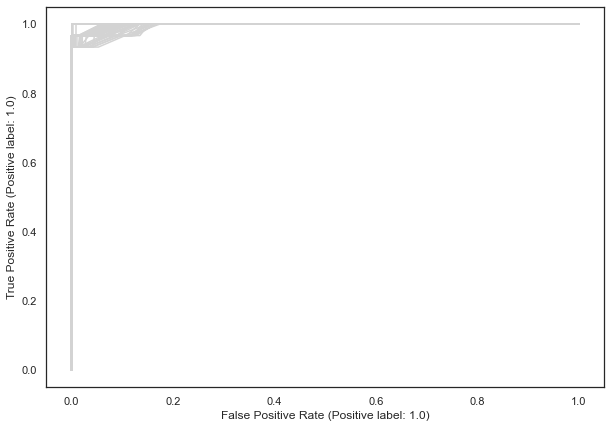

In [507]:
####
#FOR THE 10 BEST PERFORMING PARAMETERS IN no_cite_models, DO EVALUATIONS ON 10 RANDOM STATE SPLITS
####

param_dict = sorted(no_cite_models, key = lambda x: x[1])[-11:-1]
fig = plt.figure()
ax = plt.subplot(111)
auc_list = []
data = original_clean_c

for x in range(10):
    params = {'max_depth': int(param_dict[x][0]['max_depth']), 'gamma': param_dict[x][0]['gamma'],
                              'learning_rate': param_dict[x][0]['learning_rate'], 'n_estimators': param_dict[x][0]['n_estimators'],
                              'scale_pos_weight': param_dict[x][0]['scale_pos_weight'], 'colsample_bytree': param_dict[x][0]['colsample_bytree']}
    X = data.iloc[:,:-1] # Feature matrix in pd.DataFrame format
    y = data.iloc[:,-1] # Target vector in pd.Series format
    
    for q in range(10):

        # Making train and test sets for both X and y
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify = y)

        # Instantiate an XGBoost object with hyperparameters
        xgb_clf = xgb.XGBClassifier(params = params,
                                    objective='binary:logistic', booster='gbtree', 
                                    n_jobs=2, eval_metric = 'logloss')

        # Train the model with train data sets
        xgb_clf.fit(X_train, y_train)

        prob = np.array(pd.DataFrame(xgb_clf.predict_proba(X_train))[1])
        for x in range(len(prob)):
            if prob[x] > mean(np.array(pd.DataFrame(xgb_clf.predict_proba(X_train))[1])):
                prob[x] = 1
            else:
                prob[x] = 0

        y_pred = prob
        y_true = y_train # True values

        print("Accuracy: ", np.round(accuracy_score(y_true, y_pred), 3))

        auc_list.append(roc_auc_score(y_train, xgb_clf.predict_proba(X_train)[:, 1]))

        #less ugly step curve
        plot_roc_curve(xgb_clf, X_train, y_train, color='lightgrey', ax=ax)

ax.get_legend().remove()
print(auc_list)
print('AUC: ' + str(np.mean(auc_list)))

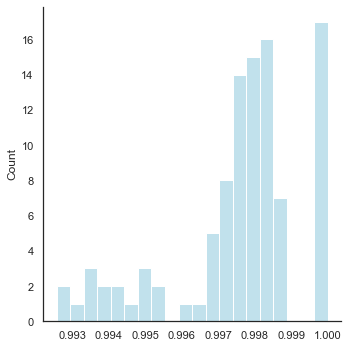

In [508]:
#from the 10 best models, 100 aucs in a histogram
sns.displot(auc_list, bins = 20, color='lightblue')

### predictions

In [484]:
#100 iterations using random state and 10 best params
#for each best param, do 10 predictions using random states

data = original_clean_c
param_dict = sorted(original_models, key = lambda x: x[1])[-11:-1]
pred_list = []
prediction_matrix = pd.DataFrame(original_clean.reset_index()['species'])  
models_list_nc = []

for x in range(10):
    params = {'max_depth': int(param_dict[x][0]['max_depth']), 'gamma': param_dict[x][0]['gamma'],
                              'learning_rate': param_dict[x][0]['learning_rate'], 'n_estimators': param_dict[x][0]['n_estimators'],
                              'scale_pos_weight': param_dict[x][0]['scale_pos_weight'], 'colsample_bytree': param_dict[x][0]['colsample_bytree']}
    
    for u in range(10):
        X, y = data.iloc[:,:-1], data.iloc[:,-1]
        #stratify to make sure the 1s are distributed evenly
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify = y)
        
        model = XGBClassifier(params=params, booster='gbtree', objective='binary:logistic', eval_metric = 'logloss')
        model.fit(X_train, y_train)
        
        models_list_nc.append(model)

        #predictions in an array
        y = model.predict_proba(X_test)

        #match prediction to the species for this split
        probability_table = X_test.reset_index() #get the species in the test set
        probability_table['probability'] = pd.DataFrame(pd.DataFrame(y)[1]) #get the probabilities
        probability_table = probability_table[['species', 'probability']]
        #put the prediction in the big df
        for a in range(len(prediction_matrix)):
            for b in range(len(probability_table)):
                if prediction_matrix.loc[a, 'species'] == probability_table.loc[b, 'species']:
                    prediction_matrix.loc[a, str(x) + '.' + str(u)] = probability_table.loc[b, 'probability']

[02:26:19] WARNING: ..\src\learner.cc:573: 
Parameters: { "params" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[02:26:21] WARNING: ..\src\learner.cc:573: 
Parameters: { "params" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[02:26:22] WARNING: ..\src\learner.cc:573: 
Parameters: { "params" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[02:26:24] WARNI

[02:27:02] WARNING: ..\src\learner.cc:573: 
Parameters: { "params" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[02:27:04] WARNING: ..\src\learner.cc:573: 
Parameters: { "params" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[02:27:05] WARNING: ..\src\learner.cc:573: 
Parameters: { "params" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[02:27:07] WARNI

[02:27:43] WARNING: ..\src\learner.cc:573: 
Parameters: { "params" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[02:27:44] WARNING: ..\src\learner.cc:573: 
Parameters: { "params" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[02:27:46] WARNING: ..\src\learner.cc:573: 
Parameters: { "params" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[02:27:48] WARNI

[02:28:24] WARNING: ..\src\learner.cc:573: 
Parameters: { "params" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[02:28:26] WARNING: ..\src\learner.cc:573: 
Parameters: { "params" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[02:28:28] WARNING: ..\src\learner.cc:573: 
Parameters: { "params" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[02:28:29] WARNI

In [485]:
#get a prediction table with the mean probability and percentile for each species

prediction_matrix['probability'] = pd.DataFrame(prediction_matrix.mean(axis=1))
top_predictions = prediction_matrix
top_predictions['percentile'] = top_predictions.probability.rank(pct=True)
top_predictions = top_predictions[top_predictions['percentile'] >= 0.9].reset_index(drop=True)
top_predictions = top_predictions[['species', 'probability', 'percentile']].reset_index(drop=True)

#add real labels
top_predictions = getstatus(top_predictions, 'leish')
top_predictions = top_predictions.fillna(0)

#sort by probability
final_predictions = top_predictions.sort_values(by ='probability', ascending=False).reset_index(drop=True)
final_predictions

,species,probability,percentile,potential/proven
0,Nyssomyia antunesi,0.959292,1.000000,1.0
1,Nyssomyia intermedia,0.939440,0.998047,2.0
2,Nyssomyia whitmani,0.918056,0.996094,2.0
3,Psychodopygus lainsoni,0.890583,0.994141,0.0
4,Psathyromyia (Psathyromyia) dendrophyla,0.842107,0.992188,0.0
5,Psathyromyia (Psathyromyia) shannoni,0.836944,0.990234,2.0
6,Bichromomyia flaviscutellata,0.787153,0.988281,2.0
7,Pintomyia (Pintomyia) pessoai,0.785797,0.986328,1.0
8,Psychodopygus davisi,0.785327,0.984375,2.0
9,Nyssomyia neivai,0.696279,0.982422,2.0


### probablity distributions

In [497]:
density = prediction_matrix.set_index('species')
density = density.loc[final_predictions['species'].to_list()]

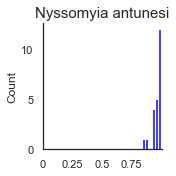

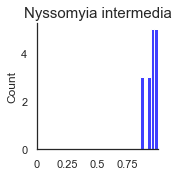

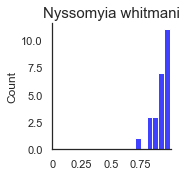

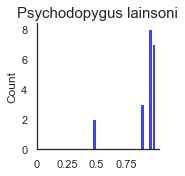

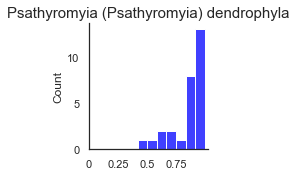

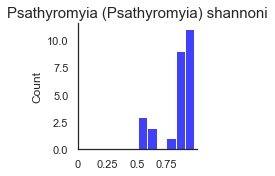

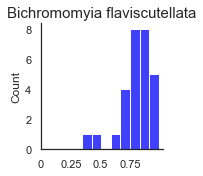

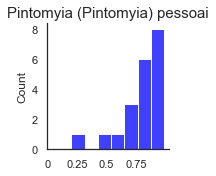

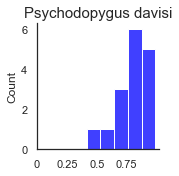

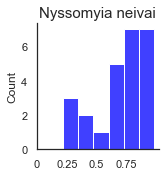

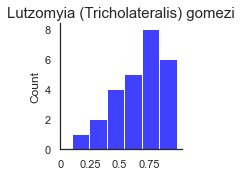

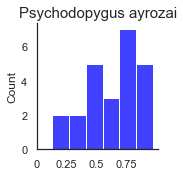

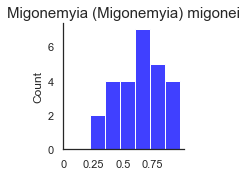

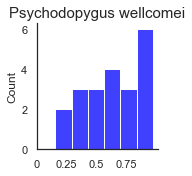

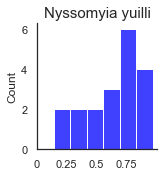

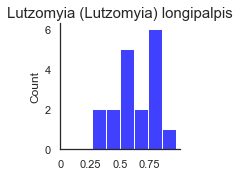

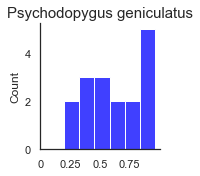

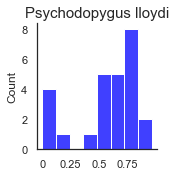

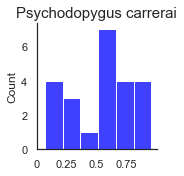

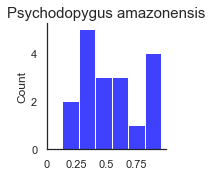

In [498]:
for x in range(20):
    sandfly = density.reset_index().loc[x, 'species']
    p = list(prediction_matrix.set_index('species').loc[sandfly])
    g = sns.displot(p, color='blue')
    g.fig.set_figwidth(2)
    g.fig.set_figheight(2)
    plt.title(sandfly, size=15)
    plt.xticks(ticks=[0, 0.25, 0.5, 0.75], labels=[0, 0.25, 0.5, 0.75])

### variable importance

In [496]:
importance = var_impt(models_list_nc).head(40).round(3)
importance

,feature,importance,std,count
0,subtribe_Psychodopygina,35.660,13.568,100.0
1,genus_Pintomyia,29.415,13.340,94.0
2,bites.man,24.840,5.667,100.0
3,log.ecoregion.breadth,24.410,6.184,100.0
4,log.rainfall,19.390,7.189,100.0
5,mh.flfs,18.131,7.662,99.0
6,log.crops.cover,15.820,6.173,100.0
7,canopy,14.810,4.359,100.0
8,flii,14.030,4.529,100.0
9,mh.ma,13.268,8.601,97.0


In [487]:
#get a dataframe with the feature, and lower and higher confidence bound for its importance
var_confidence = pd.DataFrame()
var_confidence['feature'] = 0
var_confidence['lower'] = 0
var_confidence['higher'] = 0

impten = fscore(models_list_nc)

for x in range(len(var_impt(models_list_nc))):
    feature = var_impt(models_list_nc)['feature'].to_list()[x]
    impt = var_impt(models_list_nc)['importance'].to_list()[x]
    var_confidence.loc[x, 'feature'] = feature
    var_confidence.loc[x, 'importance'] = impt
    var_confidence.loc[x, 'lower'] = getconf_interval_var(impten[impten['feature'] == feature]['importance'])[0]
    var_confidence.loc[x, 'higher'] = getconf_interval_var(impten[impten['feature'] == feature]['importance'])[1]

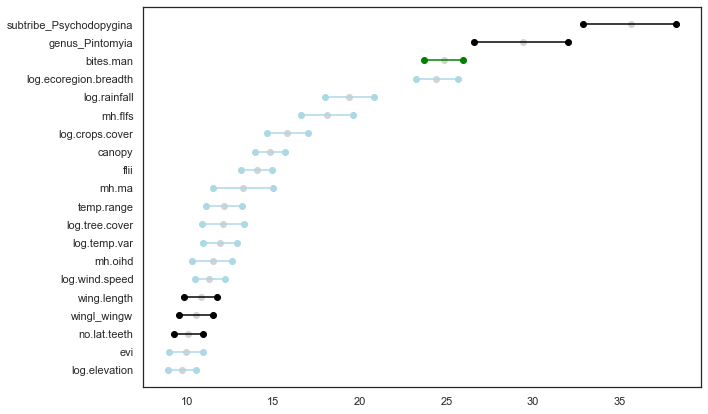

In [502]:
# plot the importances with their confidence intervals
x = var_confidence.head(20)['feature'].to_list()
y = var_confidence.head(20)['importance'].to_list()
lower = var_confidence['lower'].head(20)
higher = var_confidence['higher'].head(20)

color_list = ['black', 'black', 'green', 'lightblue', 'lightblue', 'lightblue', 'lightblue', 'lightblue', 'lightblue', 'lightblue',
              'lightblue', 'lightblue', 'lightblue', 'lightblue', 'lightblue', 'black', 'black', 'black', 'lightblue', 'lightblue']

plt.scatter(y, x, color = 'lightgrey')
#using https://stackoverflow.com/questions/59747313/how-to-plot-confidence-interval-in-python
for lower,upper,y in zip(var_confidence['lower'].head(20), var_confidence['higher'].head(20), range(len(var_confidence))):
    plt.plot((lower,upper),(y,y),'ro-',color = color_list[y])
color='color_list[y]'
plt.yticks(range(len(var_confidence.head(20))), list(var_confidence['feature'].head(20)))

# plt.errorbar(y, x, fmt="o")
plt.rcParams["figure.figsize"] = (10,7)
plt.gca().invert_yaxis()
# plt.show()

### pdp

In [493]:
og = pd.read_csv('final2/vector trait data final.csv')
data = original_clean_c
X, y = data.iloc[:,:-1], data.iloc[:,-1]

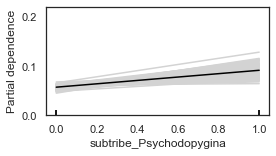

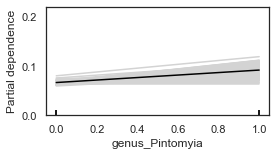

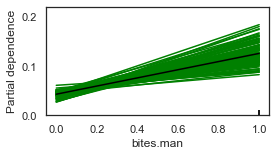

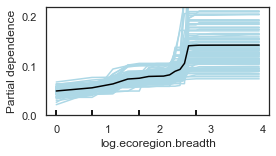

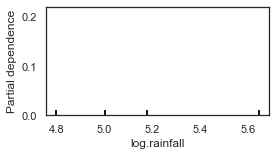

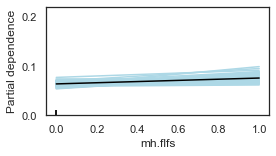

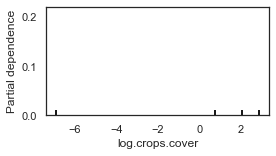

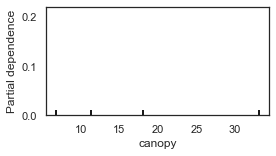

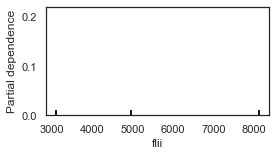

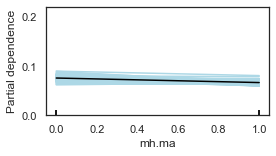

In [503]:
# fig = plt.figure()
# ax = plt.subplot(111)
model_type = models_list_nc
color_list = ['lightgrey', 'lightgrey', 'green', 'lightblue', 'lightblue', 'lightblue', 'lightblue', 'lightblue', 'lightblue', 'lightblue',
              'lightblue', 'lightblue', 'lightblue', 'lightblue', 'lightblue', 'lightgrey', 'lightgrey', 'lightgrey', 'lightblue', 'lightblue']

for a in range(10):
    fig = plt.figure()
    ax = plt.subplot(111)

    variable = importance.loc[a, 'feature']
    color = color_list[a]

    model0_plot = plot_partial_dependence(model_type[0], X, [variable], ax=ax,  line_kw={"color": color})
    for x in range(1, 100):
        model_plot = plot_partial_dependence(model_type[x], X, [variable], ax=model0_plot.axes_,  line_kw={"color": color})

    plt.ylim((0.0,0.22))

    #get average line
    ax = plt.gca()
    line = ax.lines[0]
    x_array = line.get_xdata()

    y_array = ax.lines[0].get_ydata()
    for i in range(1, 100):
        y_array += ax.lines[i].get_ydata()
    y_array = y_array/100
    fig.set_size_inches(4, 2)
    plt.plot(x_array, y_array, color = 'black')

# #histogram behind
# ax2 = ax.twinx()
# df_var = og['citations'].to_list()
# histogram = plt.hist(df_var, range=(0, 1), color = 'lightgrey', bins = 5, alpha = 0.4)

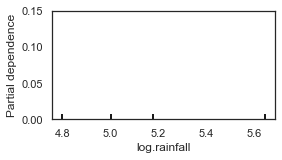

In [504]:
model_type = models_list_nc
fig = plt.figure()
ax = plt.subplot(111)

variable = 'log.rainfall'
color = 'lightblue'

model0_plot = plot_partial_dependence(model_type[0], X, [variable], ax=ax,  line_kw={"color": color})
for x in range(1, 100):
    model_plot = plot_partial_dependence(model_type[x], X, [variable], ax=model0_plot.axes_,  line_kw={"color": color})

plt.ylim((0.0,0.15))

#get average line
ax = plt.gca()
line = ax.lines[0]
x_array = line.get_xdata()

y_array = ax.lines[0].get_ydata()
for i in range(1, 100):
    y_array += ax.lines[i].get_ydata()
y_array = y_array/100
fig.set_size_inches(4, 2)
plt.plot(x_array, y_array, color = 'black')

# potential - 1 and 2

In [689]:
original = pd.read_csv('final2/one hot encoded original data.csv')
original = original.drop(columns=['Argentina', 'Belize','Bolivia', 'Brazil', 'Canada', 'CaymanIslands', 'Chile', 'Colombia',
                                  'Costa.Rica', 'Cuba', 'Dominican.Republic', 'Ecuador', 'El.Salvador', 'French.Guiana',
                                  'Guadeloupe', 'Guatemala', 'Grenada', 'Guyana', 'Haiti', 'Honduras', 'Jamaica','Martinica',
                                  'Mexico', 'Nicaragua', 'Panama', 'Paraguay','PuertoRico', 'Peru', 'Suriname',
                                  'TrinidadTobago', 'Uruguay', 'USA', 'Venezuela','VirginIslands'])
status = pd.read_csv('final2/sandfly status.csv')
#if sandfly is a proven vector for any species of leish, mark it in a new column 'cl' as 1
status['leish'] = 0
for i in range(len(status)):
    if 2 in status.values.tolist()[i]:
        status.loc[i, 'leish'] = 2
    elif 1 in status.values.tolist()[i]:
        status.loc[i, 'leish'] = 2

#get cleaned train datasets in a list
parasite = 'leish'
for j in range(len(original)):
    for i in range(len(status)):
        if original.loc[j, 'species'] == status.loc[i, 'species']:
            original.loc[j, parasite] = status.loc[i, parasite]

#fill the remaining vector status column with 0s, then binarize the status
original[parasite] = original[parasite].fillna(0).map(lambda x : x//2)
#set the index as the species name
original = original.set_index('species')
#drop unnecessary columns
original_clean = original.drop(columns=['Unnamed: 0'])

In [716]:
original_clean['leish'].value_counts()

0.0    443
1.0     69
Name: leish, dtype: int64

In [690]:
####LOOK AT CORRELLATED VARIABLES: take out more than 0.7
#tribe_Hertigiini is corr w 'genus_Warileya'
#subtribe_hertigiina is corr w 'genus_Warileya'
#peri is corr w semi.domestic
#'genus_Brumptomyia' is corr w 'subtribe_Brumptomyiina'
#'genus_Micropygomyia' is corr w 'subtribe_Sergentomyiina'
#
# pd.DataFrame(original_clean.corr()).to_csv('correllation.csv')
original_clean = original_clean.drop(columns=['subtribe_Sergentomyiina', 'subtribe_Brumptomyiina',
                                              'peri', 'subtribe_Hertigiina', 'tribe_Hertigiini'])

In [693]:
## From the hyperopt docs

from hyperopt import hp
from hyperopt import fmin, tpe
'''
## For the argument named 'a', choose either of the two tuples, each of which has a second
## argument drawn from a given distribution and given a name ('c1'/'c2')
space = hp.choice('a',
    [
        ('case 1', 1 + hp.lognormal('c1', 0, 1)),
        ('case 2', hp.uniform('c2', -10, 10))
    ])

# minimize the objective over the space
from hyperopt import fmin, tpe, space_eval
best = fmin(objective, space, algo=tpe.suggest, max_evals=100)

'''
###TRY TO GET THE AUC, CHANGE THE THRESHHOLD PROBABILITY

def val_test(best, train_x, train_y, val_x, val_y, graph=False):
    params = {'max_depth': int(best['max_depth']), 'gamma': best['gamma'],
                  'learning_rate': best['learning_rate'], 'n_estimators': int(best['n_estimators']),
                  'scale_pos_weight': int(best['scale_pos_weight']), 'colsample_bytree': best['colsample_bytree']}
    model = XGBClassifier(use_label_encoder=False, eval_metric = 'logloss', **params)
    model.fit(train_x, train_y)

    

    #use the mean of the probabilities as the threshold for a positive prediction
    prob = np.array(pd.DataFrame(model.predict_proba(val_x))[1])
    for x in range(len(prob)):
        if prob[x] > mean(np.array(pd.DataFrame(model.predict_proba(val_x))[1])):
            prob[x] = 1
        else:
            prob[x] = 0
        
    y_preds = prob
    
               
#         plot_roc_curve(model, val_x, val_y)
#         plt.ylabel('True Positive Rate')
#         plt.xlabel('False Positive Rate')
#         plt.show()
               
    return roc_auc_score(val_y, y_preds)

original_models_putative = []
def do_nested_cv(data):
    '''
    - Split data into train, test
    - Split train into k (stratified) folds
    '''
    
    # Begin code here
    X, y = data.iloc[:,:-1], data.iloc[:,-1]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify = y)
    
    cv = StratifiedKFold(n_splits=3)
    folds = cv.split(X_train, y_train)
    

    
    # End code here
    models_with_scores = []
    for (train, val) in folds:
        '''
        - Split x into n more (stratified) folds
        - Now, use Bayesian optimization to minimize objective function
        - After Bayesian optimization, evaluate the model on val and store the model
        '''
        # Begin code here
        train_x, train_y = X_train.iloc[train], y_train.iloc[train]
        val_x, val_y = X_train.iloc[val], y_train.iloc[val]
        inner_cv = StratifiedKFold(n_splits=3)
        
        inner_folds = inner_cv.split(train_x, train_y)
        inner_folds = [(train,test) for train, test in inner_folds]
        
        def objective_function(params):
            '''
            Given a set of n (inner) folds, train n models and return the average validation loss over all folds.
            '''
            scores = []
            params = {'max_depth': int(params[0]), 'gamma': params[1],
                      'learning_rate': params[2], 'n_estimators': int(params[3]),
                      'scale_pos_weight': int(params[4]), 'colsample_bytree': params[5]}

            for (itrain, ival) in inner_folds:
                # Begin code here
                '''
                - Train a model on n
                - Evaluate on val
                - Store the score to return the average over all folds
                '''
                inner_train_x, inner_train_y = train_x.iloc[itrain], train_y.iloc[itrain]
                inner_val_x, inner_val_y = train_x.iloc[ival], train_y.iloc[ival]
                
                

                model = XGBClassifier(use_label_encoder=False, eval_metric = 'logloss', **params)
                model.fit(inner_train_x, inner_train_y)
            
                y_preds = model.predict(inner_val_x)
                scores.append(1-roc_auc_score(inner_val_y, y_preds))

            return np.mean(scores)
                # End code here
            
        
        #bayes

        space = hp.choice('a', [(hp.uniform('max_depth', 0, 10),
                                 hp.uniform('gamma', 10, 1000), 
                                 hp.uniform('learning_rate', 0, 1), 
                                 hp.uniform('n_estimators', 100, 200),
                                 hp.uniform('scale_pos_weight', 0, 15),
                                 hp.uniform('colsample_bytree', 0.2, 1)
                                )])
        

            
        best = fmin(objective_function, space, algo=tpe.suggest, max_evals=100)
        models_with_scores.append((best, val_test(best, train_x, train_y, val_x, val_y)))
        
        original_models_putative.append((best, val_test(best, train_x, train_y, val_x, val_y)))

        # End code here
        

    
    '''
    - Now, there are k models. Pick the best one, or create an ensemble model
    '''
    # Begin code here
    models_with_scores = sorted(models_with_scores, key = lambda x: x[1])
    best_params_overall = models_with_scores[-1][0]
    
    final_test_score = val_test(best_params_overall, X_train, y_train, X_test, y_test, True)
    print("Final Test Score is " + str(final_test_score))
    print('best = ' + str(best_params_overall))
    # End code here
    


In [694]:
### get out a list that has the parameters and aucs

for i in range(100):
    data = original_clean
    do_nested_cv(data)

100%|██████████████████████████████████████████████| 100/100 [01:22<00:00,  1.21trial/s, best loss: 0.2649978362003678]
Final Test Score is 0.7937399678972713
best = {'a': 0, 'colsample_bytree': 0.46237021953797386, 'gamma': 12.488881931585878, 'learning_rate': 0.35802046291160844, 'max_depth': 1.0647375706802729, 'n_estimators': 138.02993496751472, 'scale_pos_weight': 7.1491078793187945}
100%|█████████████████████████████████████████████| 100/100 [01:14<00:00,  1.34trial/s, best loss: 0.19387644704100404]
Final Test Score is 0.8126003210272873
best = {'a': 0, 'colsample_bytree': 0.910373180110458, 'gamma': 19.612107858263727, 'learning_rate': 0.14780277421874807, 'max_depth': 9.127559263769705, 'n_estimators': 195.09838950021873, 'scale_pos_weight': 14.183745170826093}
100%|█████████████████████████████████████████████| 100/100 [01:19<00:00,  1.25trial/s, best loss: 0.23030942334739804]
Final Test Score is 0.8820224719101123
best = {'a': 0, 'colsample_bytree': 0.4581200309523964, 'gam

100%|█████████████████████████████████████████████| 100/100 [01:22<00:00,  1.21trial/s, best loss: 0.22215460348371743]
Final Test Score is 0.7917335473515248
best = {'a': 0, 'colsample_bytree': 0.3586261934732498, 'gamma': 12.620817970505758, 'learning_rate': 0.49112654095271385, 'max_depth': 4.7265040730684555, 'n_estimators': 173.6271342486103, 'scale_pos_weight': 4.90981286330947}
100%|██████████████████████████████████████████████| 100/100 [01:20<00:00,  1.24trial/s, best loss: 0.1946743481553609]
Final Test Score is 0.6565008025682183
best = {'a': 0, 'colsample_bytree': 0.4037667384695492, 'gamma': 35.66430297638642, 'learning_rate': 0.040963155187031, 'max_depth': 7.319083945393901, 'n_estimators': 101.69610705652126, 'scale_pos_weight': 9.57610215518085}
100%|█████████████████████████████████████████████| 100/100 [01:19<00:00,  1.26trial/s, best loss: 0.22376392946013202]
Final Test Score is 0.7074638844301765
best = {'a': 0, 'colsample_bytree': 0.2916921275183837, 'gamma': 12.

100%|██████████████████████████████████████████████| 100/100 [01:24<00:00,  1.19trial/s, best loss: 0.2340960727036676]
Final Test Score is 0.8350722311396469
best = {'a': 0, 'colsample_bytree': 0.6080276599416883, 'gamma': 23.09108961633902, 'learning_rate': 0.45130348056155745, 'max_depth': 6.80305118973687, 'n_estimators': 190.20692435376088, 'scale_pos_weight': 13.166237337924986}
100%|█████████████████████████████████████████████| 100/100 [01:21<00:00,  1.23trial/s, best loss: 0.22757762631180356]
Final Test Score is 0.8069823434991975
best = {'a': 0, 'colsample_bytree': 0.6641498559296928, 'gamma': 10.811515677289862, 'learning_rate': 0.24745567248189598, 'max_depth': 3.402826973615878, 'n_estimators': 145.21418559886942, 'scale_pos_weight': 13.3670183337568}
100%|█████████████████████████████████████████████| 100/100 [01:31<00:00,  1.10trial/s, best loss: 0.25359731688845616]
Final Test Score is 0.8519261637239166
best = {'a': 0, 'colsample_bytree': 0.5528744612574057, 'gamma': 

100%|█████████████████████████████████████████████| 100/100 [01:22<00:00,  1.22trial/s, best loss: 0.26833820188250573]
Final Test Score is 0.8876404494382022
best = {'a': 0, 'colsample_bytree': 0.4922295633068584, 'gamma': 22.485228180466837, 'learning_rate': 0.3466081415972743, 'max_depth': 1.0976758699103901, 'n_estimators': 199.82162719027508, 'scale_pos_weight': 10.575516452418364}
100%|█████████████████████████████████████████████| 100/100 [01:26<00:00,  1.15trial/s, best loss: 0.21650167694471487]
Final Test Score is 0.8350722311396469
best = {'a': 0, 'colsample_bytree': 0.45034128919447874, 'gamma': 10.341158285680926, 'learning_rate': 0.800070689022741, 'max_depth': 2.1652039049689975, 'n_estimators': 176.14298797669372, 'scale_pos_weight': 6.409915411620347}
100%|██████████████████████████████████████████████| 100/100 [01:18<00:00,  1.28trial/s, best loss: 0.2776290165530672]
Final Test Score is 0.7768860353130016
best = {'a': 0, 'colsample_bytree': 0.9581543766943468, 'gamma

100%|█████████████████████████████████████████████| 100/100 [01:14<00:00,  1.33trial/s, best loss: 0.22710429514226982]
Final Test Score is 0.7937399678972713
best = {'a': 0, 'colsample_bytree': 0.5446247073586554, 'gamma': 10.1187563035277, 'learning_rate': 0.3025232839778036, 'max_depth': 3.368036298244988, 'n_estimators': 105.40896303192474, 'scale_pos_weight': 7.750897094307391}
100%|██████████████████████████████████████████████| 100/100 [01:23<00:00,  1.20trial/s, best loss: 0.2844449853943525]
Final Test Score is 0.7937399678972713
best = {'a': 0, 'colsample_bytree': 0.6203591262354815, 'gamma': 10.566305406140806, 'learning_rate': 0.29105704602528865, 'max_depth': 7.679205061123186, 'n_estimators': 150.0796359226119, 'scale_pos_weight': 10.82441537987768}
100%|█████████████████████████████████████████████| 100/100 [01:26<00:00,  1.15trial/s, best loss: 0.22488640051931186]
Final Test Score is 0.8126003210272873
best = {'a': 0, 'colsample_bytree': 0.6028213449032425, 'gamma': 19

100%|█████████████████████████████████████████████| 100/100 [01:28<00:00,  1.14trial/s, best loss: 0.28171318835875797]
Final Test Score is 0.7467897271268057
best = {'a': 0, 'colsample_bytree': 0.7167028408494798, 'gamma': 17.50838384051753, 'learning_rate': 0.9856052385312808, 'max_depth': 3.7339524303274105, 'n_estimators': 183.72838514374567, 'scale_pos_weight': 12.302181629778252}
100%|█████████████████████████████████████████████| 100/100 [01:25<00:00,  1.17trial/s, best loss: 0.20733257600346208]
Final Test Score is 0.8386837881219904
best = {'a': 0, 'colsample_bytree': 0.20164711407125904, 'gamma': 52.86434938014546, 'learning_rate': 0.341199533503155, 'max_depth': 1.8129067173276745, 'n_estimators': 119.23576636815937, 'scale_pos_weight': 6.9599050556891235}
100%|██████████████████████████████████████████████| 100/100 [01:22<00:00,  1.21trial/s, best loss: 0.2625770853618955]
Final Test Score is 0.7728731942215088
best = {'a': 0, 'colsample_bytree': 0.8887552791845731, 'gamma'

100%|█████████████████████████████████████████████| 100/100 [01:30<00:00,  1.10trial/s, best loss: 0.22878123985718915]
Final Test Score is 0.7917335473515248
best = {'a': 0, 'colsample_bytree': 0.4793629381761827, 'gamma': 12.589563691359361, 'learning_rate': 0.20882459445844836, 'max_depth': 6.577792271558529, 'n_estimators': 174.60895714081613, 'scale_pos_weight': 10.922304171863908}
100%|█████████████████████████████████████████████| 100/100 [01:25<00:00,  1.16trial/s, best loss: 0.30765173644920485]
Final Test Score is 0.8013643659711075
best = {'a': 0, 'colsample_bytree': 0.22266083251249924, 'gamma': 11.758344105540106, 'learning_rate': 0.2504363761110194, 'max_depth': 2.6515960327306756, 'n_estimators': 119.40779706370327, 'scale_pos_weight': 14.51504061028405}
100%|██████████████████████████████████████████████| 100/100 [01:28<00:00,  1.13trial/s, best loss: 0.2362057773450178]
Final Test Score is 0.7524077046548956
best = {'a': 0, 'colsample_bytree': 0.4428483884916933, 'gamm

100%|█████████████████████████████████████████████| 100/100 [01:30<00:00,  1.11trial/s, best loss: 0.23431245266688305]
Final Test Score is 0.7825040128410914
best = {'a': 0, 'colsample_bytree': 0.30642114888014405, 'gamma': 18.35625749068839, 'learning_rate': 0.09501537395732314, 'max_depth': 2.8042497017886934, 'n_estimators': 198.41169862248273, 'scale_pos_weight': 10.141125882412489}
100%|█████████████████████████████████████████████| 100/100 [01:30<00:00,  1.11trial/s, best loss: 0.28456669912366106]
Final Test Score is 0.8426966292134832
best = {'a': 0, 'colsample_bytree': 0.5064811802970443, 'gamma': 34.68369839796703, 'learning_rate': 0.27608648915194217, 'max_depth': 7.9591665786213985, 'n_estimators': 125.92052327867376, 'scale_pos_weight': 14.622689445456398}
100%|██████████████████████████████████████████████| 100/100 [01:22<00:00,  1.21trial/s, best loss: 0.3039191820837391]
Final Test Score is 0.823836276083467
best = {'a': 0, 'colsample_bytree': 0.28982699300807374, 'gam

[09:47:10] WARNING: ..\src\learner.cc:573: 
Parameters: { "params" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Accuracy:  0.893
[09:47:11] WARNING: ..\src\learner.cc:573: 
Parameters: { "params" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Accuracy:  0.786
[09:47:11] WARNING: ..\src\learner.cc:573: 
Parameters: { "params" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you fi

Accuracy:  0.864
[09:47:22] WARNING: ..\src\learner.cc:573: 
Parameters: { "params" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Accuracy:  0.854
[09:47:23] WARNING: ..\src\learner.cc:573: 
Parameters: { "params" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Accuracy:  0.835
[09:47:23] WARNING: ..\src\learner.cc:573: 
Parameters: { "params" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open a

Accuracy:  0.854
[09:47:34] WARNING: ..\src\learner.cc:573: 
Parameters: { "params" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Accuracy:  0.816
[09:47:35] WARNING: ..\src\learner.cc:573: 
Parameters: { "params" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Accuracy:  0.903
[09:47:35] WARNING: ..\src\learner.cc:573: 
Parameters: { "params" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open a

Accuracy:  0.825
[09:47:49] WARNING: ..\src\learner.cc:573: 
Parameters: { "params" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Accuracy:  0.835
[09:47:49] WARNING: ..\src\learner.cc:573: 
Parameters: { "params" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Accuracy:  0.845
[09:47:50] WARNING: ..\src\learner.cc:573: 
Parameters: { "params" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open a

Accuracy:  0.757
[09:48:07] WARNING: ..\src\learner.cc:573: 
Parameters: { "params" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Accuracy:  0.835
[09:48:07] WARNING: ..\src\learner.cc:573: 
Parameters: { "params" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Accuracy:  0.825
[09:48:08] WARNING: ..\src\learner.cc:573: 
Parameters: { "params" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open a

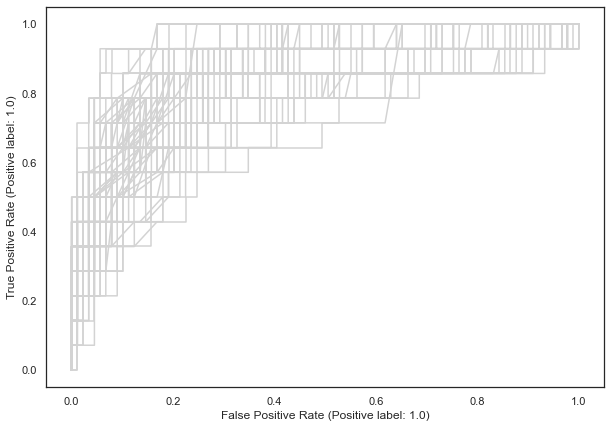

In [695]:
####
#FOR THE 10 BEST PERFORMING PARAMETERS IN no_cite_models, DO EVALUATIONS ON 10 RANDOM STATE SPLITS
####

param_dict = sorted(original_models_putative, key = lambda x: x[1])[-11:-1]
fig = plt.figure()
ax = plt.subplot(111)
auc_list = []
data = original_clean

for x in range(10):
    params = {'max_depth': int(param_dict[x][0]['max_depth']), 'gamma': param_dict[x][0]['gamma'],
                              'learning_rate': param_dict[x][0]['learning_rate'], 'n_estimators': param_dict[x][0]['n_estimators'],
                              'scale_pos_weight': param_dict[x][0]['scale_pos_weight'], 'colsample_bytree': param_dict[x][0]['colsample_bytree']}
    X = data.iloc[:,:-1] # Feature matrix in pd.DataFrame format
    y = data.iloc[:,-1] # Target vector in pd.Series format
    
    for q in range(10):

        # Making train and test sets for both X and y
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify = y)

        # Instantiate an XGBoost object with hyperparameters
        xgb_clf = xgb.XGBClassifier(params = params,
                                    objective='binary:logistic', booster='gbtree', 
                                    n_jobs=2, eval_metric = 'logloss')

        # Train the model with train data sets
        xgb_clf.fit(X_train, y_train)

        prob = np.array(pd.DataFrame(xgb_clf.predict_proba(X_test))[1])
        for x in range(len(prob)):
            if prob[x] > mean(np.array(pd.DataFrame(xgb_clf.predict_proba(X_test))[1])):
                prob[x] = 1
            else:
                prob[x] = 0

        y_pred = prob
        y_true = y_test # True values

        print("Accuracy: ", np.round(accuracy_score(y_true, y_pred), 3))

        auc_list.append(roc_auc_score(y_test, xgb_clf.predict_proba(X_test)[:, 1]))

        #less ugly step curve
        plot_roc_curve(xgb_clf, X_test, y_test, color='lightgrey', ax=ax)

ax.get_legend().remove()
print(auc_list)
print('AUC: ' + str(np.mean(auc_list)))

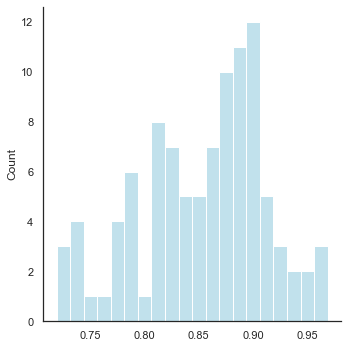

In [696]:
#from the 10 best models, 100 aucs in a histogram
sns.displot(auc_list, bins = 20, color='lightblue')

In [702]:
#100 iterations using random state and 10 best params
#for each best param, do 10 predictions using random states

data = original_clean
param_dict = sorted(original_models_putative, key = lambda x: x[1])[-11:-1]
pred_list = []
prediction_matrix = pd.DataFrame(original_clean.reset_index()['species'])  
models_list_putative = []

for x in range(10):
    params = {'max_depth': int(param_dict[x][0]['max_depth']), 'gamma': param_dict[x][0]['gamma'],
                              'learning_rate': param_dict[x][0]['learning_rate'], 'n_estimators': param_dict[x][0]['n_estimators'],
                              'scale_pos_weight': param_dict[x][0]['scale_pos_weight'], 'colsample_bytree': param_dict[x][0]['colsample_bytree']}
    
    for u in range(10):
        X, y = data.iloc[:,:-1], data.iloc[:,-1]
        #stratify to make sure the 1s are distributed evenly
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify = y)
        
        model = XGBClassifier(params=params, booster='gbtree', objective='binary:logistic', eval_metric = 'logloss')
        model.fit(X_train, y_train)
        
        models_list_nc.append(model)

        #predictions in an array
        y = model.predict_proba(X)

        #match prediction to the species for this split
        probability_table = X.reset_index() #get the species in the test set
        probability_table['probability'] = pd.DataFrame(pd.DataFrame(y)[1]) #get the probabilities
        probability_table = probability_table[['species', 'probability']]
        #put the prediction in the big df
        for a in range(len(prediction_matrix)):
            for b in range(len(probability_table)):
                if prediction_matrix.loc[a, 'species'] == probability_table.loc[b, 'species']:
                    prediction_matrix.loc[a, str(x) + '.' + str(u)] = probability_table.loc[b, 'probability']

[10:05:22] WARNING: ..\src\learner.cc:573: 
Parameters: { "params" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[10:05:30] WARNING: ..\src\learner.cc:573: 
Parameters: { "params" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[10:05:37] WARNING: ..\src\learner.cc:573: 
Parameters: { "params" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[10:05:44] WARNI

[10:08:21] WARNING: ..\src\learner.cc:573: 
Parameters: { "params" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[10:08:28] WARNING: ..\src\learner.cc:573: 
Parameters: { "params" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[10:08:35] WARNING: ..\src\learner.cc:573: 
Parameters: { "params" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[10:08:42] WARNI

[10:11:17] WARNING: ..\src\learner.cc:573: 
Parameters: { "params" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[10:11:24] WARNING: ..\src\learner.cc:573: 
Parameters: { "params" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[10:11:32] WARNING: ..\src\learner.cc:573: 
Parameters: { "params" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[10:11:39] WARNI

[10:14:14] WARNING: ..\src\learner.cc:573: 
Parameters: { "params" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[10:14:21] WARNING: ..\src\learner.cc:573: 
Parameters: { "params" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[10:14:28] WARNING: ..\src\learner.cc:573: 
Parameters: { "params" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[10:14:35] WARNI

In [703]:
#get a prediction table with the mean probability and percentile for each species

prediction_matrix['probability'] = pd.DataFrame(prediction_matrix.mean(axis=1))
top_predictions = prediction_matrix
top_predictions['percentile'] = top_predictions.probability.rank(pct=True)
top_predictions = top_predictions[top_predictions['percentile'] >= 0.9].reset_index(drop=True)
top_predictions = top_predictions[['species', 'probability', 'percentile']].reset_index(drop=True)

#########
status = pd.read_csv('final2/sandfly status.csv')
#if sandfly is a proven vector for any species of leish, mark it in a new column 'cl' as 1
status['leish'] = 0
for i in range(len(status)):
    if 2 in status.values.tolist()[i]:
        status.loc[i, 'leish'] = 2
    elif 1 in status.values.tolist()[i]:
        status.loc[i, 'leish'] = 1
#########

#add real labels
top_predictions = getstatus(top_predictions, 'leish')
top_predictions = top_predictions.fillna(0)

#sort by probability
final_predictions = top_predictions.sort_values(by ='probability', ascending=False).reset_index(drop=True)
final_predictions

,species,probability,percentile,potential/proven
0,Nyssomyia whitmani,0.995179,1.000000,2.0
1,Lutzomyia (Lutzomyia) longipalpis,0.992838,0.998047,2.0
2,Nyssomyia antunesi,0.991961,0.996094,1.0
3,Pintomyia (Pintomyia) fischeri,0.988181,0.994141,2.0
4,Nyssomyia intermedia,0.985547,0.992188,2.0
5,Psychodopygus davisi,0.985462,0.990234,2.0
6,Psathyromyia (Psathyromyia) shannoni,0.983140,0.988281,2.0
7,Pintomyia (Pifanomyia) verrucarum,0.980755,0.986328,2.0
8,Pintomyia (Pintomyia) pessoai,0.980581,0.984375,1.0
9,Psychodopygus wellcomei,0.979040,0.982422,2.0


In [722]:
prediction_matrix['probability'] = pd.DataFrame(prediction_matrix.mean(axis=1))
top_predictions = prediction_matrix
top_predictions['percentile'] = top_predictions.probability.rank(pct=True)
top_predictions = top_predictions[top_predictions['probability'] >= 0.5].reset_index(drop=True)
top_predictions = top_predictions[['species', 'probability', 'percentile']].reset_index(drop=True)
top_predictions = top_predictions.sort_values(by ='probability', ascending=False).reset_index(drop=True)
top_predictions = getstatus(top_predictions, 'leish')
top_predictions = top_predictions.fillna(0)
top_predictions.to_csv('test predictions.csv')

In [701]:
density = prediction_matrix.set_index('species')
density = density.loc[final_predictions['species'].to_list()]

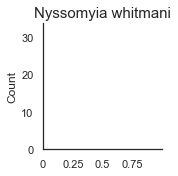

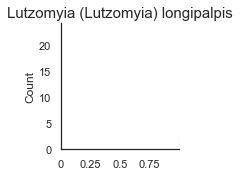

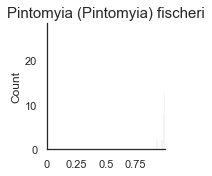

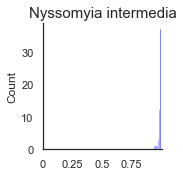

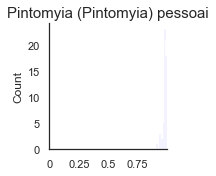

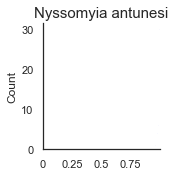

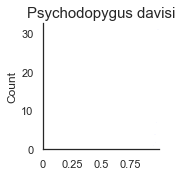

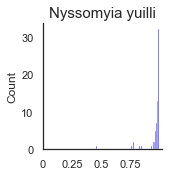

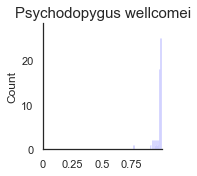

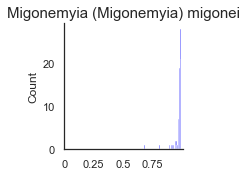

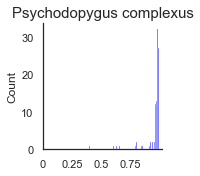

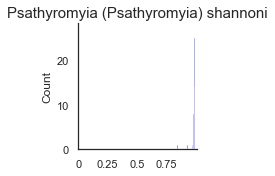

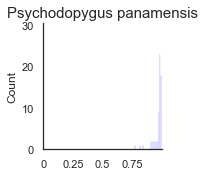

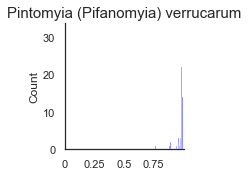

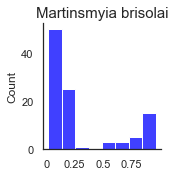

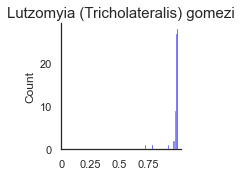

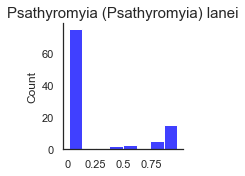

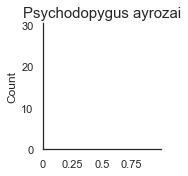

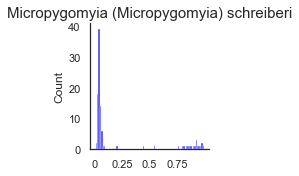

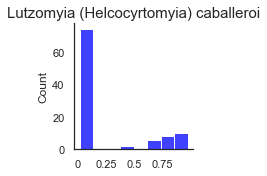

In [723]:
for x in range(20):
    sandfly = density.reset_index().loc[x, 'species']
    p = list(prediction_matrix.set_index('species').loc[sandfly])
    g = sns.displot(p, color='blue')
    g.fig.set_figwidth(2)
    g.fig.set_figheight(2)
    plt.title(sandfly, size=15)
    plt.xticks(ticks=[0, 0.25, 0.5, 0.75], labels=[0, 0.25, 0.5, 0.75])